In [1]:
#import user modules
#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import sys
my_path = "../../Python/"
if my_path not in sys.path:
    sys.path.append(my_path)
 
for place in sys.path: 
    print(place)

from tools import *
from fit_funcs import *
from entropy import *
import costfun.costfun as cost
import utils.figures as fig_help
from RandomMatrixTheory import goe
import utils.tools as tools

import importlib as imp
def reload_modules():
    imp.reload(cost)
    imp.reload(fig_help)

import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
latex_engine = 'xelatex'
latex_elements = {'preamble':r'\usepackage{physics}'}

%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:200])
colors_ls_cyc = itertools.cycle(colors_ls)

markers_ls = ['o','s','v', 'D', '<', 'X', '^', '*', '+']
markers = itertools.cycle(markers_ls)

linestyle_ls = ['-','--',':', '-.']
linestyle = itertools.cycle(linestyle_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import digamma
from scipy.special import polygamma
from scipy.special import lambertw
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
from scipy import integrate
from scipy import fft
 
# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from os import sep as kPSep
from os.path import exists


config_disorder = 0
config_disorder_sorted = 0

if config_disorder and config_disorder_sorted:
    base_dir = "../results_conf_dis_sort/"
elif config_disorder:
    base_dir = "../results_conf_dis/"
else:
    base_dir = "../results/"

print(base_dir[2:])

/Users/rafal.swietek/Projects/CODES/QHamSolver/QuantumSun/Jupyter_Python
/Users/rafal.swietek/opt/anaconda3/lib/python39.zip
/Users/rafal.swietek/opt/anaconda3/lib/python3.9
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/lib-dynload

/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/aeosa
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions
/Users/rafal.swietek/.ipython
../../Python/
/results/


## GAP RATIO

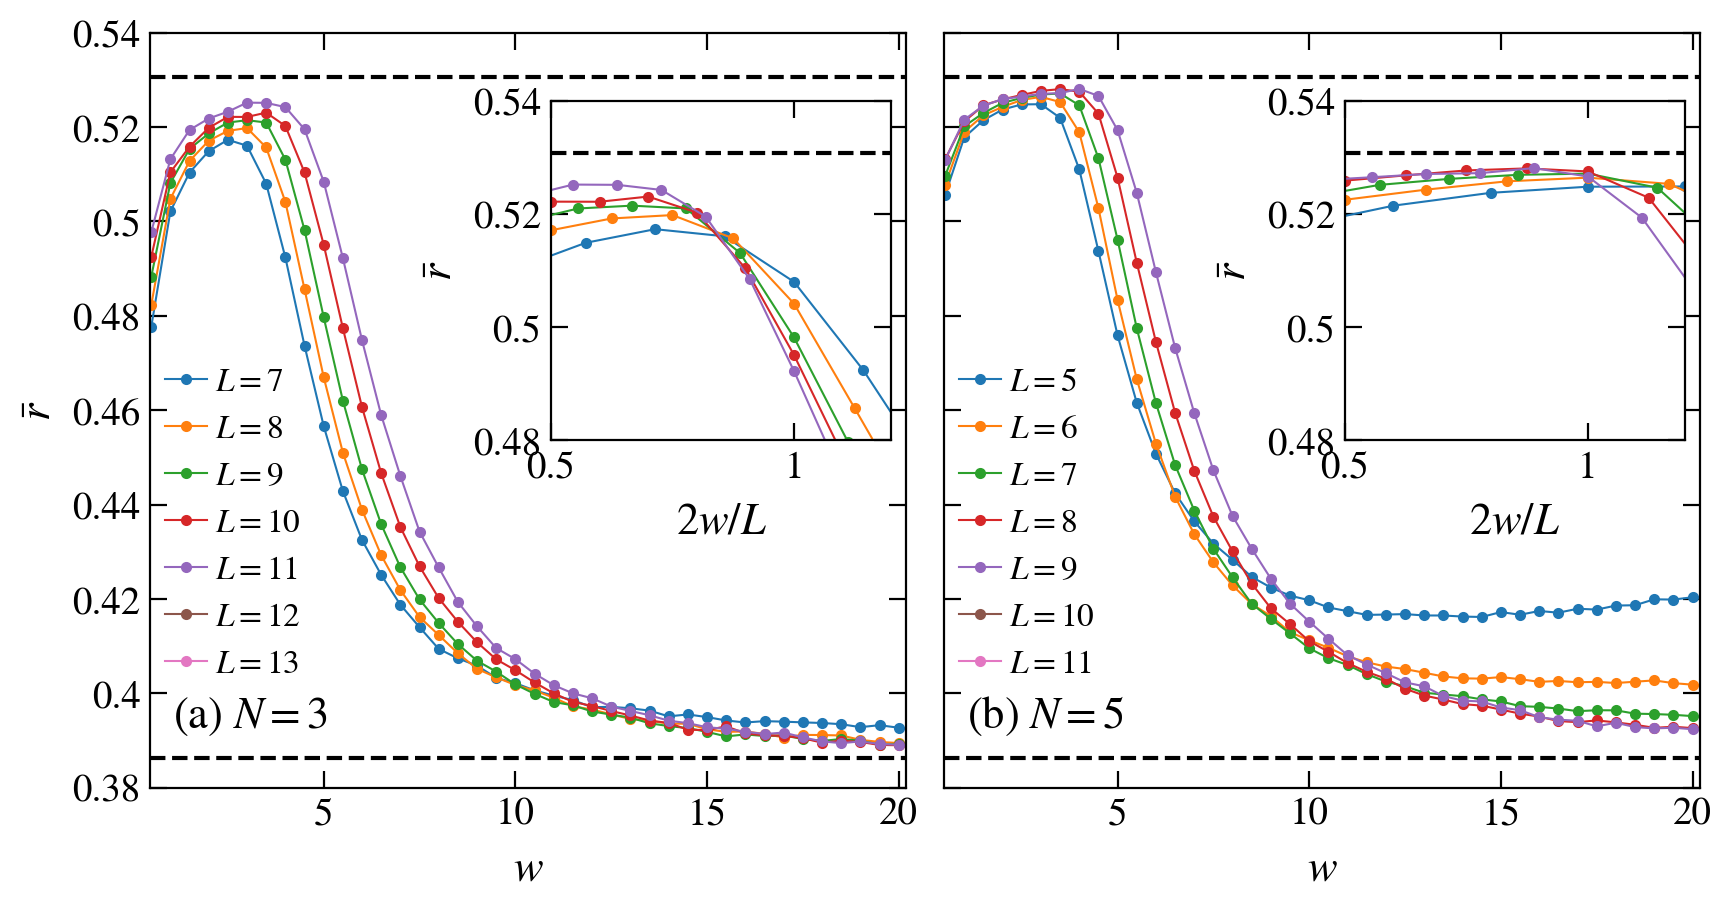

In [79]:
L_total=15
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N


plot_gaps = 1

b = 1.5

w_vals = [10.0]
if config_disorder and config_disorder_sorted:
    w_vals = np.linspace(1.0, 4.9, 40)
    w_vals = np.round(10**w_vals, 5)
elif config_disorder:
    w_vals = np.linspace(0.5, 35.0, 70)
else:   
    w_vals = np.linspace(0.5, 20.0, 40)

sub_sizes = np.arange(0, L+1)
fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200, sharey=True)

sizes = np.arange(10, 17, 1)

rescale = 0

nu = 500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

folder_base = f'./collected data/'
folder = folder_base + base_dir[3:] + f"nu={nu}/"
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)

if rescale:
    if config_disorder and config_disorder_sorted:
        xlab = r"$w / 2^L$"
    else:
        xlab = r"$2w / L$"
else:
    xlab = r"$w$"
    
ylab = r"$\bar{r}$"

inset = []
for idx1, N in enumerate([3, 5]):
    inset.append( axis[idx1].inset_axes([0.53, 0.46, 0.45, 0.45]) )
    
    disorder = []
    gaps = []
    for L_total in sizes:
        sub_sizes = np.arange(0, L_total+1)
        L = L_total - N
        LA = L_total // 2
        name_out = folder + f'_L={L},N={N},gamma={gamma},alfa={alfa}.hdf5'

        if exists(name_out):
            with h5py.File(name_out, "r") as file:
                w_vals       = np.array(file.get('disorder'))
                gap_ratio    = np.array(file.get('gap_ratio'))
                entropy      = np.array(file.get('entropy'))
                entropy_site = np.array(file.get('single_site_entropy'))
        else:
            entropy         = np.zeros((sub_sizes.size, w_vals.size))
            entropy_site    = np.zeros((sub_sizes.size, w_vals.size))
            gap_ratio       = np.zeros((w_vals.size))
            realisations    = np.zeros((w_vals.size))
            for ii, w in enumerate(w_vals):
                name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
                if not exists(name): 
                    name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='_beta.hdf5')
                #print(name)
                if exists(name):
                    with h5py.File(name, "r") as file:
                        energies = np.array(file.get('mean energies'))
                        ratio = np.array(file.get('gap ratio'))
                        realis = np.array(file.get('realisations'))[0]
                        realisations[ii] = realis
                        
                        dim = energies.size
                        num = frac(dim)
                        # print(dim, num)
                        E_av = np.mean(energies)
                        index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                        
                        my_min = int(index_meanE - num / 2)
                        if my_min < 0: my_min = 0;  

                        my_max = int(index_meanE + num / 2)
                        if my_max >= dim: my_max = dim

                        try:
                            if num == 500:          gap_ratio[ii] = np.array(file.get('gap ratio 500'))
                            elif num == dim//2:     gap_ratio[ii] = np.array(file.get('gap ratio D/2'))
                            else:
                                # print("otherwise")
                                gap_ratio[ii] = np.mean(ratio[my_min : my_max]) if my_min > 0 and my_max < dim and num < dim else np.mean(ratio)
                            for LA in sub_sizes:
                                S = np.array(file.get('entropies'))[LA]
                                Ssite = np.array(file.get('single_site_entropy'))[LA]
                                entropy[LA][ii]         = np.mean(S[my_min : my_max]) if my_min > 0 and my_max < dim and num < dim else np.mean(S)
                                entropy_site[LA][ii]    = np.mean(Ssite[my_min : my_max]) if my_min > 0 and my_max < dim and num < dim else np.mean(Ssite)
                        except TypeError:
                            print(ratio)
                else:
                    print(name)

            hf = h5py.File(name_out, 'w')
            hf.create_dataset('disorder',               w_vals.shape,           data = w_vals)
            hf.create_dataset('gap_ratio',              gap_ratio.shape,        data = gap_ratio)
            hf.create_dataset('entropy',                entropy.shape,          data = entropy)
            hf.create_dataset('single_site_entropy',    entropy_site.shape,     data = entropy_site)
            hf.create_dataset('realisations',           realisations.shape,     data = realisations)
            hf.close()
        if rescale:
            if config_disorder and config_disorder_sorted:
                wx = w_vals / np.exp(L*np.log(2)) 
            else: 
                wx = 2 * w_vals / L**b
        else:
            wx = w_vals
        disorder.append(wx)
        gaps.append(gap_ratio)   
        
    # par, crit_pars, costfun, status = cost.get_crit_points(x=np.array(disorder), y=np.array(gaps), vals=sizes - N, crit_fun='free', scaling_ansatz='classic', seed=412438923)
    # print(crit_pars)
    
    # rescale_fun = cost.resc_functions_dict['classic']
    # critical_fun = cost.crit_functions_dict['free']
    # xlab = cost.scale_ansatz_label['classic']('W')

    for ii, L in enumerate(sizes - N):
        axis[idx1].plot(disorder[ii], gaps[ii], marker='o', markersize=3, lw=0.75, label=r"$L=%d$"%L)
        inset[idx1].plot(2*disorder[ii]/(L), gaps[ii], marker='o', markersize=3, lw=0.75, label=r"$L=%d$"%L)
        # axis[idx1].plot(rescale_fun(disorder[ii], sizes, ii, critical_fun, par, *crit_pars), gaps[ii], ls='--', marker='o', label=r"$L=%d$"%(L))

    axis[idx1].set_ylim(0.38,0.54)
    axis[idx1].set_xlim(0.95*min(np.array(disorder).flatten()), 1.01*max(np.array(disorder).flatten()))
    axis[idx1].axhline(y=0.3863, ls='--', color='black')
    axis[idx1].axhline(y=0.5307, ls='--', color='black')


    inset[idx1].set_ylim(0.48,0.54)
    inset[idx1].set_xlim(0.5, 1.2)
    inset[idx1].axhline(y=0.5307, ls='--', color='black')
        
    # if not config_disorder: axis[idx1].set_xlim(0, None)
    #         # axis[idx2][idx1].set_xlim(0.0,2)
    



fig_help.set_plot_elements(axis[0], ylabel=ylab, xlabel=xlab, font_size=14, set_legend=False)
fig_help.set_legend(axis[0], loc = 'center left', fontsize=12, anchor=(-0.02, 0.35))
fig_help.set_plot_elements(axis[1], ylabel="", xlabel=xlab, font_size=14, set_legend=False)
fig_help.set_legend(axis[1], loc = 'center left', fontsize=12, anchor=(-0.02, 0.35))

fig_help.set_plot_elements(inset[0], ylabel=ylab, xlabel=r"$2w/L$", font_size=14, set_legend=False)
fig_help.set_plot_elements(inset[1], ylabel=ylab, xlabel=r"$2w/L$", font_size=14, set_legend=False)

if config_disorder and config_disorder_sorted:
    for ax in axis.flatten():
        ax.set_xscale('log')

for aa in [axis, inset]:
    for ax in np.array(aa).flatten():
        ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
        ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
        ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))
        ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%g"%x))

axis[0].annotate(r"(a) $N=3$", fontsize=16, xy=(0.03, 0.08), xycoords='axes fraction')
axis[1].annotate(r"(b) $N=5$", fontsize=16, xy=(0.03, 0.08), xycoords='axes fraction')
# axis[0].set_title(r"$N=3, \gamma=%.1f$"%(gamma), fontsize=16)
# axis[1].set_title(r"$N=5, \gamma=%.1f$"%(gamma), fontsize=16)

fig.subplots_adjust(wspace = 0.05, hspace=0.05)

## ENTROPY

### BIPARTITE

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]] [[0.34657359 0.34657359 0.34657359 0.34657359 0.34657359 0.34657359
  0.34657359 0.34657359 0.34657359 0.34657359 0.34657359 0.34657359
  0.34657359 0.34657359 0.34657359 0.34657359]
 [0.69314718 0.69314718 0.69314718 0.69314718 0.693

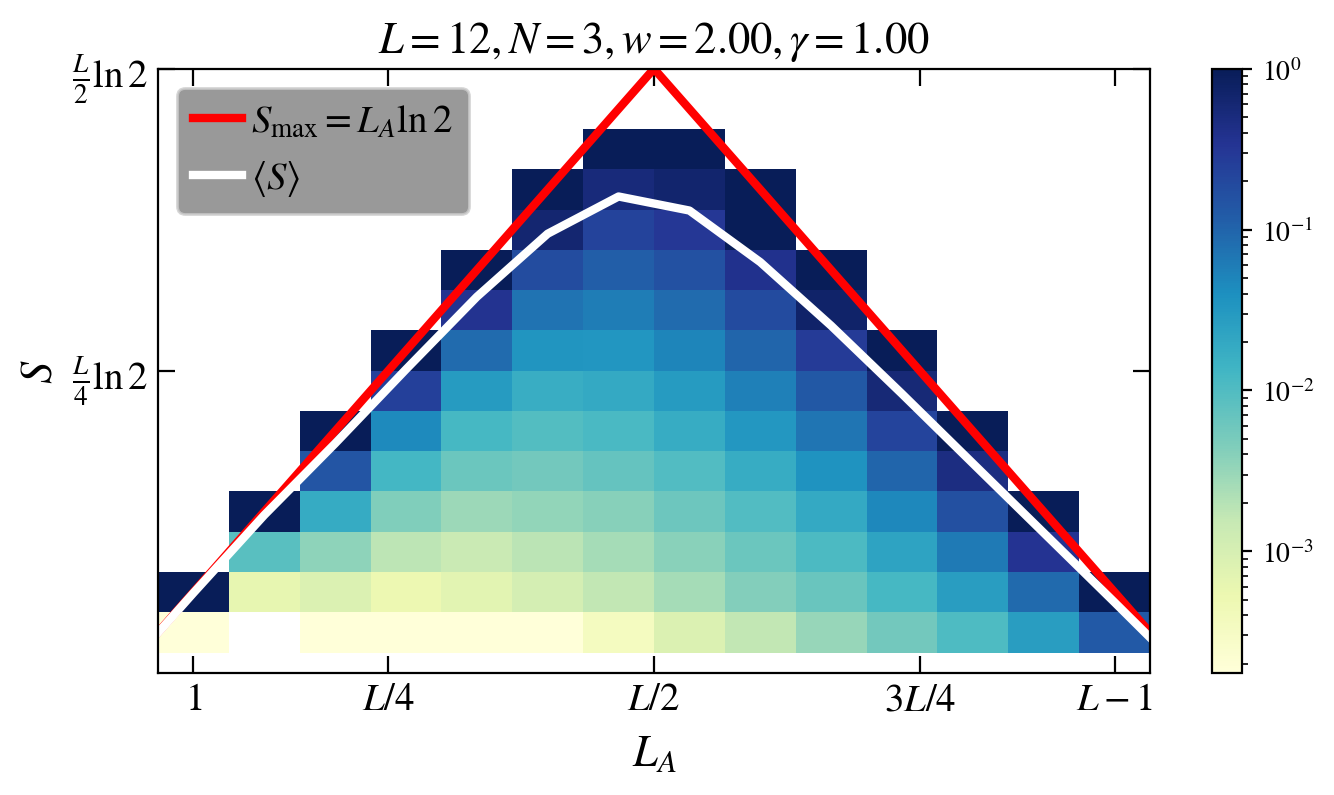

In [10]:

markers = itertools.cycle(markers_ls)

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(8,4), dpi = 200)

L_total=15
J=1.0
alfa=1.0
h=0.0

w=2.0
if config_disorder and config_disorder_sorted: # from 1.0 to 4.9
    w = 10**w

zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

entrop = np.linspace(0, L_total * np.log(2)/2, L_total + 1)
sub_sizes = np.arange(0, L_total+1)

density = np.zeros((sub_sizes.size, entrop.size-1))

average_entropy = np.zeros((sub_sizes.size))

name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
if not exists(name): name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='_beta.hdf5')
if exists(name):
    with h5py.File(name, "r") as file:
        energies = np.array(file.get('mean energies'))
        dim = energies.size

        for LA in sub_sizes:
            entropies = np.array(file.get('entropies'))[LA]

            hist, bins = np.histogram(entropies, bins=entrop, normed=True)
            hist = np.array(hist)
            #
            #hist.resize( sub_sizes.size )
            #print(bins, hist)
            density[LA] = np.array(hist)
            average_entropy[LA] = np.mean(entropies)
else:
    print(name)

#white = plt.get_cmap('seismic', 100)(0.5*np.ones(1))
upper = plt.get_cmap('YlGnBu', 100)(np.linspace(0.0, 1.0, 100))
colors = np.vstack((upper))  

mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

X, Y = np.meshgrid(sub_sizes, entrop[1:])
print(X, Y)
p = axis.pcolormesh(X, Y, np.transpose(density), shading='nearest', cmap=mymap, norm=matplotlib.colors.LogNorm(vmin=np.min(density[density > 0]), vmax=1.0))

laa = np.arange(0, L_total//2 + L_total%2 + 1)
axis.plot(laa, laa * np.log(2), c='red', lw=3)
laa = np.arange(L_total//2, L_total+1)
axis.plot(laa, (L_total - laa)*np.log(2), c='red', lw=3, label=r"$S_{\rm max}=L_A\ln2$")

axis.plot(sub_sizes, average_entropy, lw=3, c='white', label=r"$\langle S\rangle$")
axis.set_xlim(0.5, L_total-0.5)
axis.set_ylim(0.0, L_total/2*np.log(2))

fig_help.set_plot_elements(axis, ylabel="$S$", xlabel=r"$L_A$", font_size=14, set_legend=False)

xticks = [1, L_total/4, L_total/2, 3*L_total/4, L_total-1]
tick_labels = ["$1$", "$L/4$", "$L/2$", "$3L/4$", "$L-1$"]
axis.set_xticks(xticks)
axis.set_xticklabels(tick_labels)

xticks = [L_total/4*np.log(2), L_total/2*np.log(2)]
tick_labels = [r"$\frac{L}{4}\ln2$", r"$\frac{L}{2}\ln2$"]
axis.set_yticks(xticks)
axis.set_yticklabels(tick_labels)
axis.set_title(r"$L=%d, N=%d, w=%.2f, \gamma=%.2f$"%(L,N, w, gamma), fontsize=16)

# axis.xaxis.set_minor_locator(plt.NullLocator())
# axis.yaxis.set_minor_locator(plt.NullLocator())
fig.colorbar(p)
legend = axis.legend(frameon=1, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0), facecolor="gray")
plt.show()

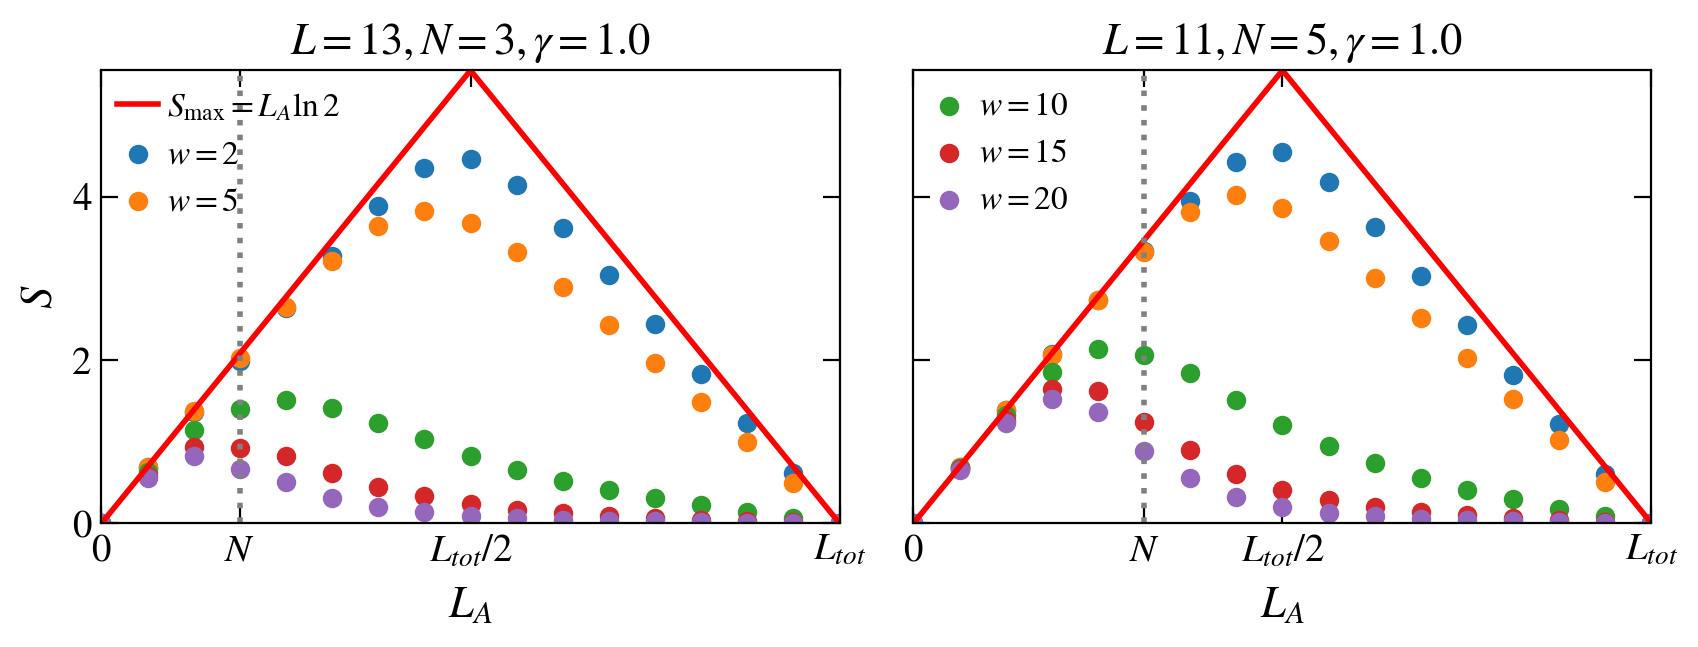

In [27]:

L_total=16
J=1.0
alfa=1.0
h=0.0
w=2.0

zeta=0.0
N=3
gamma=1.0
ini_ave=0

w_vals = np.linspace(0.5, 20., 40)

sub_sizes = np.arange(0, L_total+1)

fig, axes = plt.subplots( nrows=1, ncols=2, figsize=(10,3), dpi = 200, sharey=True)

def frac(dim):
    return 2*dim

w_vals = [10.0]
if config_disorder and config_disorder_sorted:
    w_vals = np.array([1.0, 2.0, 3.0, 4.0, 4.5])
    w_vals = np.round(10**w_vals, 5)
else:   
    w_vals = [2.0, 5.0, 10.0, 15.0, 20.0]

Ns = [3, 5]
for iiii, axis in enumerate(axes):
    N = Ns[iiii]
    L = L_total - N
    for w in w_vals:
        name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
        if not exists(name): name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='_beta.hdf5')
        entropy = np.zeros((L_total+1))
        if exists(name):
            with h5py.File(name, "r") as file:
                energies = np.array(file.get('mean energies'))
                ratio = np.array(file.get('gap ratio'))
                entropies = np.array(file.get('entropies'))
                
                dim = energies.size
                num = frac(dim)

                E_av = np.mean(energies)
                index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                
                for LA in sub_sizes:
                    my_min = int(index_meanE - num / 2)
                    if my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2) 
                    if my_max >= dim: my_max = dim

                    sample = entropies[LA]
                    if my_min > 0 and my_max < dim:
                        sample = entropies[LA][my_min : my_max]
                    
                    entropy[LA] = np.mean(sample)
                    
            axis.scatter(sub_sizes, entropy, label=legend_label("w", w))
        else:
            print(name)
    laa = np.arange(0, L_total//2 + (L_total%2) + 0.5)
    axis.plot(laa, laa * np.log(2), c='red', lw=2)
    laa = np.arange(L_total//2, L_total + 1)
    axis.plot(laa, (L_total - laa)*np.log(2), c='red', lw=2, label=r"$S_{\rm max}=L_A\ln2$")

    axis.axvline(x=N, ls=':', color='gray', lw=2)
    fig_help.set_plot_elements(axis, ylabel="$S$" if iiii == 0 else "", xlabel=r"$L_A$", font_size=14, set_legend=True)
    axis.set_xlim(0, L_total)
    axis.set_ylim(0, L_total/2 * np.log(2))

    xticks = [0, N, L_total/2, L_total]
    tick_labels = ["$0$", "$N$", "$L_{tot}/2$", "$L_{tot}$"]
    axis.set_xticks(xticks)
    axis.set_xticklabels(tick_labels)
    axis.set_title(r"$L=%d, N=%d, \gamma=%.1f$"%(L,N, gamma), fontsize=16)

    handles, labels = axis.get_legend_handles_labels()

    split_idx = 3
    if iiii == 0:    axis.legend(handles=handles[:split_idx], labels=labels[:split_idx], loc = 'upper left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,1.02))
    else:            axis.legend(handles=handles[split_idx:], labels=labels[split_idx:], loc = 'upper left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,1.02))
    # plt.gca().add_artist(l1)
fig.subplots_adjust(wspace = 0.1, hspace=0.05)

#### DISORDER FUNCTION

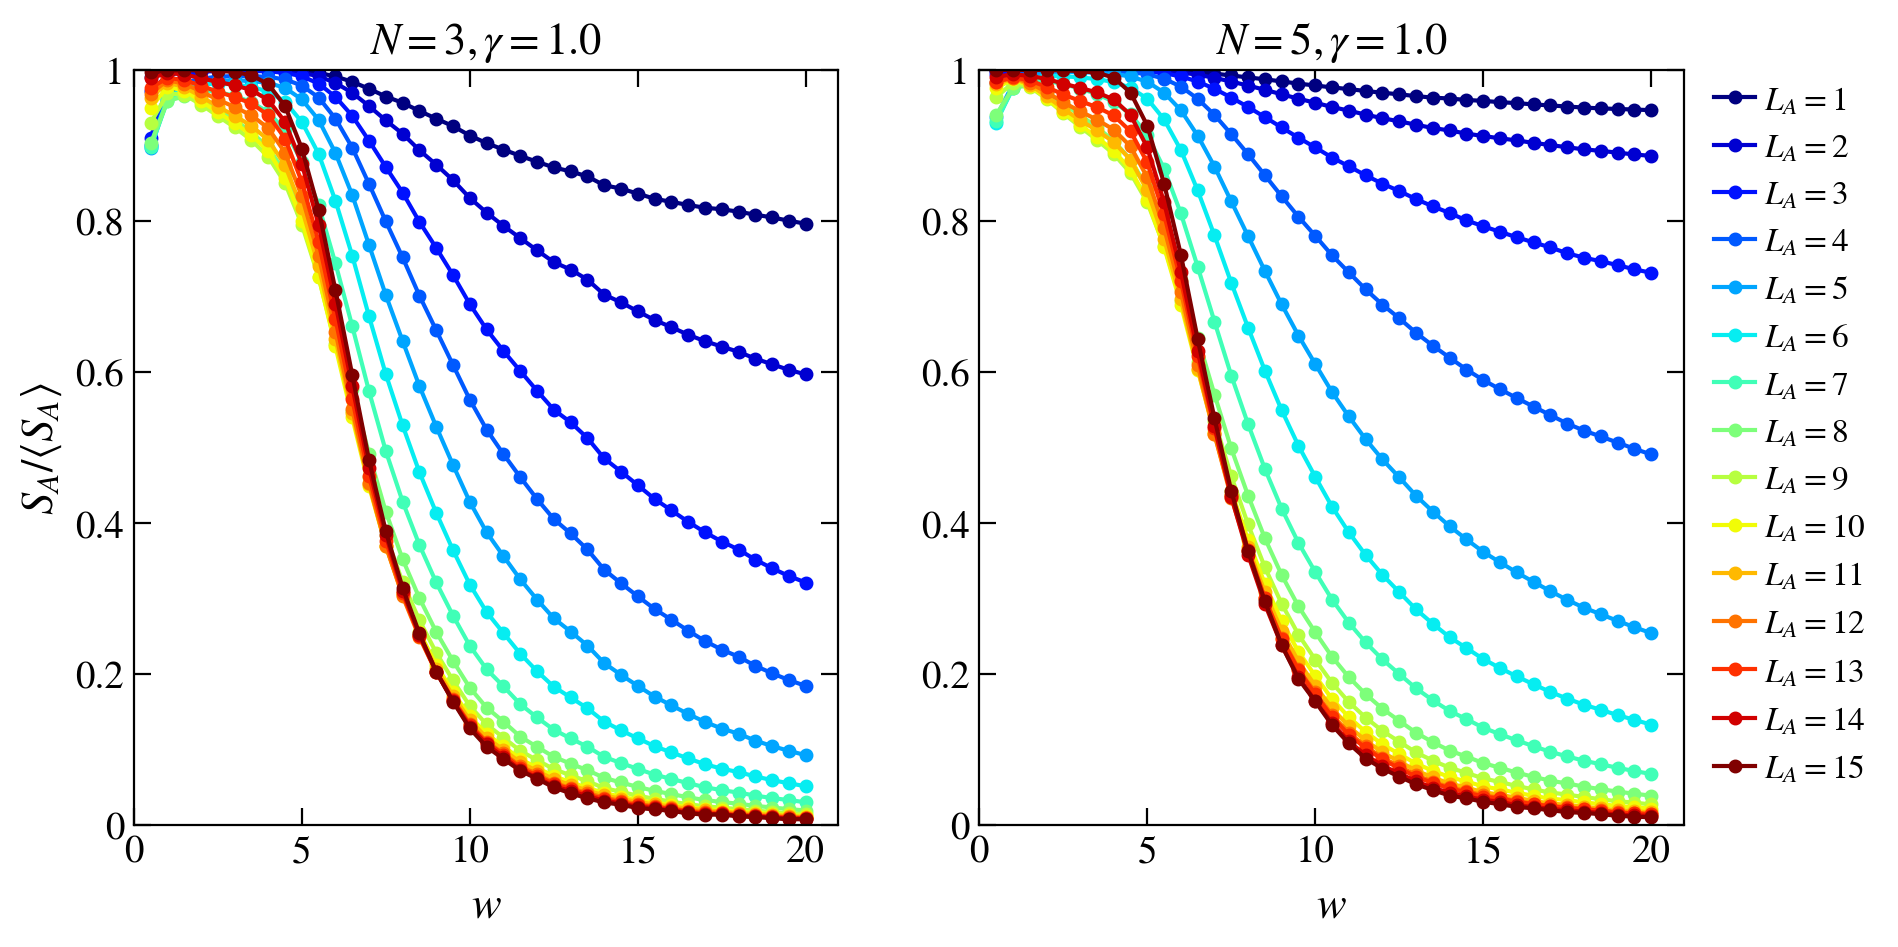

In [10]:
L_total = 16 - config_disorder - config_disorder_sorted
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0

w_vals = [10.0]
if config_disorder and config_disorder_sorted:
    w_vals = np.linspace(1.0, 4.9, 40)
    w_vals = np.round(10**w_vals, 5)
elif config_disorder:
    w_vals = np.linspace(0.5, 35.0, 70)
else:   
    w_vals = np.linspace(0.5, 20.0, 40)

sub_sizes = np.arange(0, L_total + 1)
fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200)

def frac(dim):
    return 500

for idx1, N in enumerate([3, 5]):
    colors = plt.cm.jet(np.linspace(0, 1, sub_sizes.size-2))
    L = L_total - N
    for LA in sub_sizes[1:-1]:
        entropy = np.zeros((w_vals.size))
        gap_ratio = np.zeros((w_vals.size))
        for ii, w in enumerate(w_vals):
            name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
            if not exists(name): name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='_beta.hdf5')
            #print(name)
            if exists(name):
                with h5py.File(name, "r") as file:
                    energies = np.array(file.get('mean energies'))
                    ratio = np.array(file.get('gap ratio'))
                    S = np.array(file.get('entropies'))[LA]
                    
                    dim = energies.size
                    num = frac(dim)

                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2)
                    if my_max >= dim: my_max = dim

                    sample = S
                    if my_min > 0 and my_max < dim:
                        sample = S[my_min : my_max]
                    
                    entropy[ii] = np.mean(sample)
                    gap_ratio[ii] = np.mean(ratio)
            else:
                print(name)
        axis[idx1].plot(w_vals, entropy / page(LA, L_total - LA), marker='o', markersize=4, label=r"$L_A=%d$"%LA, color=colors[LA-1])
        #axis.plot(w_vals, gap_ratio, marker='o', label=r"$L=%d$"%L)
        axis[idx1].set_ylim(0,1)
        if not config_disorder: axis[idx1].set_xlim(0, None)

fig_help.set_plot_elements(axis[0], ylabel=r"$S_{A} / \langle S_A\rangle$", xlabel=r"$w$", font_size=14, set_legend=False)
fig_help.set_plot_elements(axis[1], ylabel="",                              xlabel=r"$w$", font_size=14, set_legend=False)

if config_disorder and config_disorder_sorted:
    for ax in axis.flatten():
        ax.set_xscale('log')

axis[0].set_title(r"$N=3, \gamma=%.1f$"%(gamma), fontsize=16)
axis[1].set_title(r"$N=5, \gamma=%.1f$"%(gamma), fontsize=16)
axis[1].legend(loc = 'upper right', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.3,1.02))
fig.subplots_adjust(wspace = 0.2, hspace=0.05)

7 0.5 [2000]
7 1.0 [2000]
7 1.5 [2000]
7 2.0 [2000]
7 2.5 [2000]
7 3.0 [2000]
7 3.5 [2000]
7 4.0 [2000]
7 4.5 [2000]
7 5.0 [2000]
7 5.5 [2000]
7 6.0 [2000]
7 6.5 [2000]
7 7.0 [2000]
7 7.5 [2000]
7 8.0 [2000]
7 8.5 [2000]
7 9.0 [2000]
7 9.5 [2000]
7 10.0 [2000]
7 10.5 [2000]
7 11.0 [2000]
7 11.5 [2000]
7 12.0 [2000]
7 12.5 [2000]
7 13.0 [2000]
7 13.5 [2000]
7 14.0 [2000]
7 14.5 [2000]
7 15.0 [2000]
7 15.5 [2000]
7 16.0 [2000]
7 16.5 [2000]
7 17.0 [2000]
7 17.5 [2000]
7 18.0 [2000]
7 18.5 [2000]
7 19.0 [2000]
7 19.5 [2000]
7 20.0 [2000]
512 9
2 1
7 0.5 [2000]
7 1.0 [2000]
7 1.5 [2000]
7 2.0 [2000]
7 2.5 [2000]
7 3.0 [2000]
7 3.5 [2000]
7 4.0 [2000]
7 4.5 [2000]
7 5.0 [2000]
7 5.5 [2000]
7 6.0 [2000]
7 6.5 [2000]
7 7.0 [2000]
7 7.5 [2000]
7 8.0 [2000]
7 8.5 [2000]
7 9.0 [2000]
7 9.5 [2000]
7 10.0 [2000]
7 10.5 [2000]
7 11.0 [2000]
7 11.5 [2000]
7 12.0 [2000]
7 12.5 [2000]
7 13.0 [2000]
7 13.5 [2000]
7 14.0 [2000]
7 14.5 [2000]
7 15.0 [2000]
7 15.5 [2000]
7 16.0 [2000]
7 16.5 [2000]
7 17.0

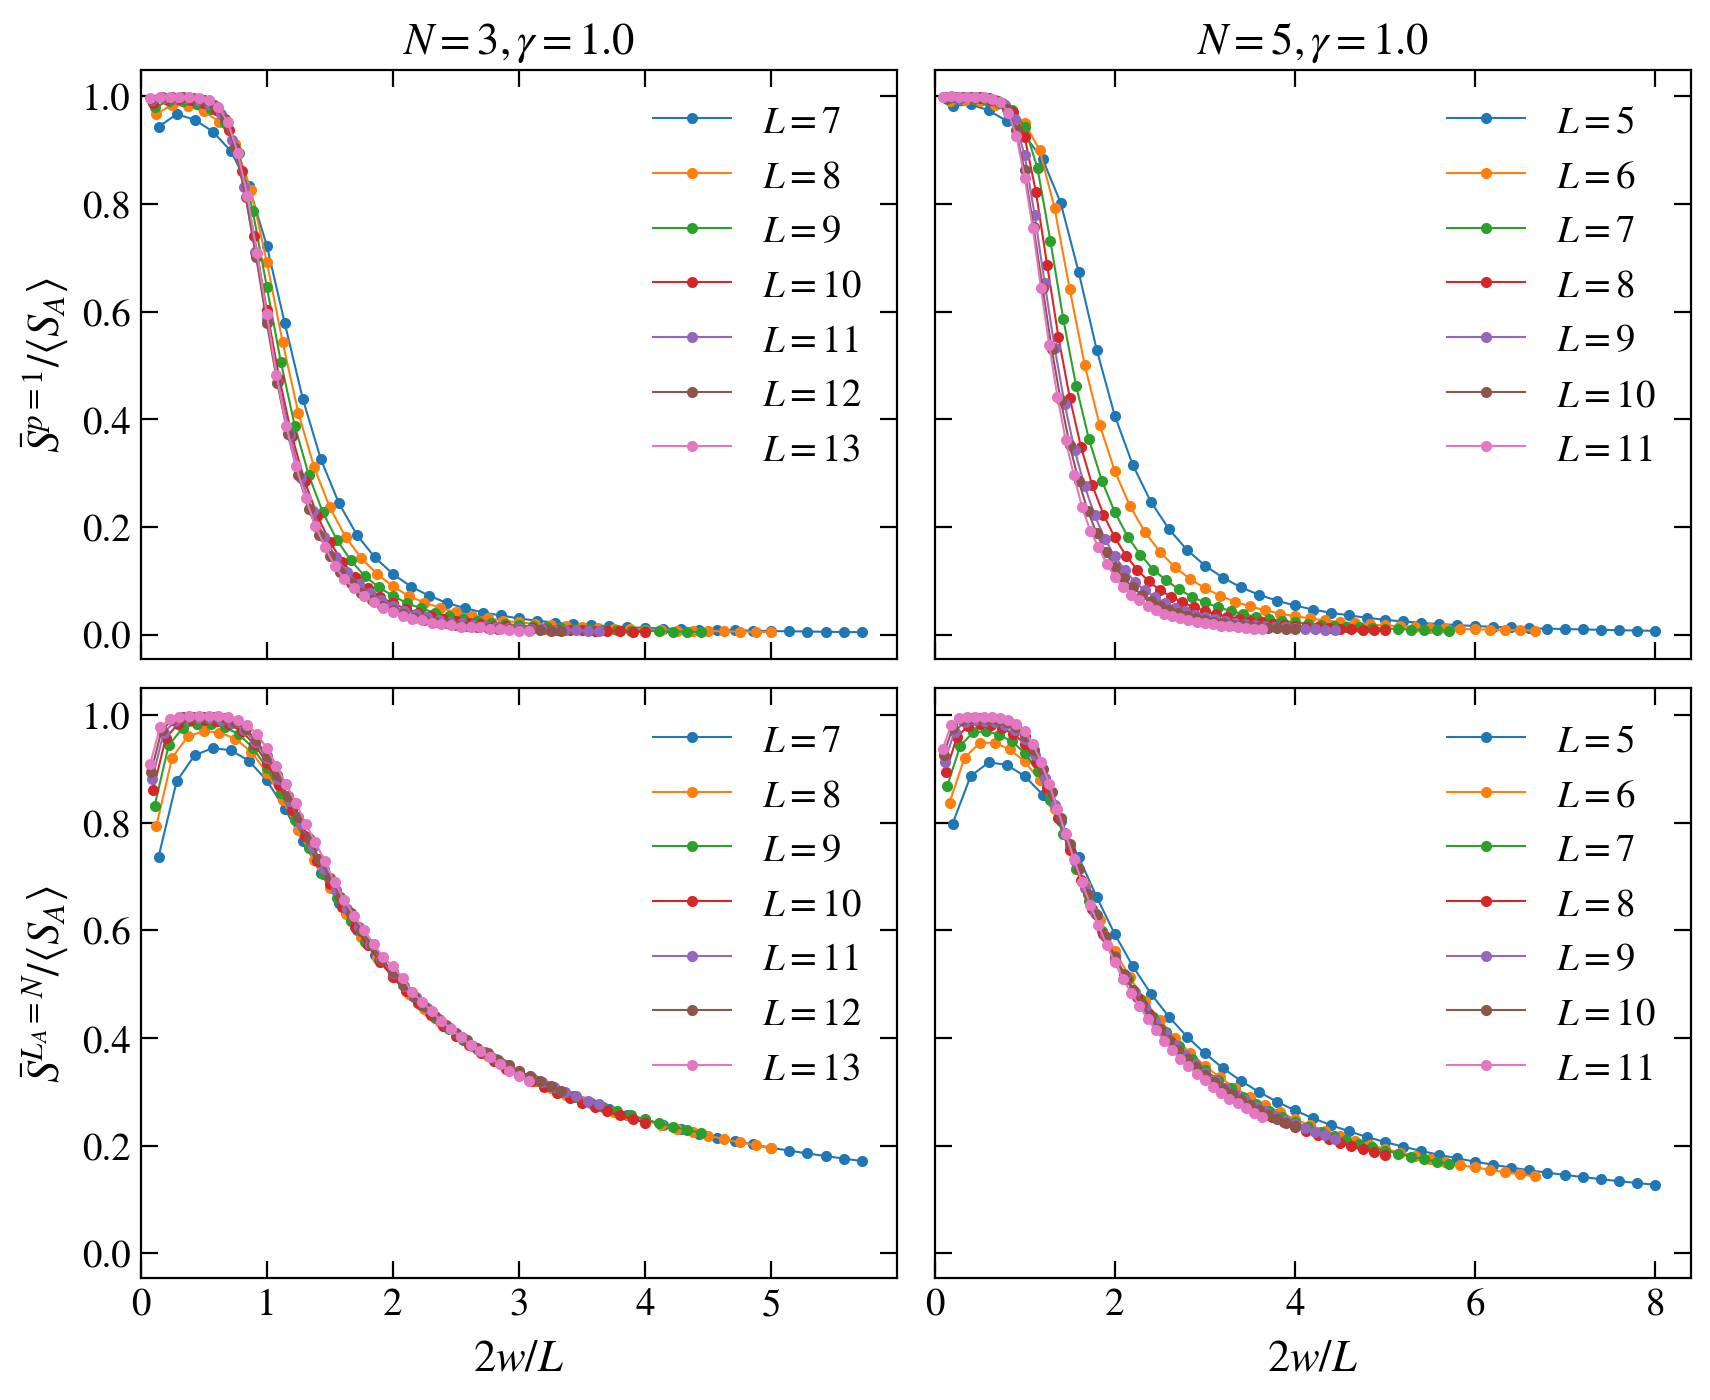

In [14]:
L_total=16
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

b = 1.

w_vals = [10.0]
if config_disorder and config_disorder_sorted:
    w_vals = np.linspace(1.0, 4.9, 40)
    w_vals = np.round(10**w_vals, 5)
elif config_disorder:
    w_vals = np.linspace(0.5, 35.0, 70)
else:   
    w_vals = np.linspace(0.5, 20.0, 40)

sub_sizes = np.arange(0, L+1)
fig, axis = plt.subplots( nrows=2, ncols=2, figsize=(10,8), dpi = 200, sharey=True)


def frac(dim):
    return 500

folder_base = f'./collected data/'
folder = folder_base + base_dir[3:]
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)

for idx1, N in enumerate([3, 5]):
    for L_total in np.arange(10, 17, 1):
        L = L_total - N
        LA = L_total // 2
        for idx2, LA in enumerate([L_total - 1, N]):
            name1 = folder + f'gap_ratio_L={L},N={N},gamma={gamma},alfa={alfa}.npy'
            name2 = folder + f'entropy_L={L},N={N},gamma={gamma},alfa={alfa}_LA={LA}.npy'
            if exists(name1) and exists(name2):
                with open(name1, 'rb') as file:   gap_ratio = np.load(file, allow_pickle=True)
                with open(name2, 'rb') as file:   entropy   = np.load(file, allow_pickle=True)
            else:
                entropy = np.zeros((w_vals.size))
                gap_ratio = np.zeros((w_vals.size))
                for ii, w in enumerate(w_vals):
                    name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
                    if not exists(name): name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='_beta.hdf5')
                    #print(name)
                    if exists(name):
                        with h5py.File(name, "r") as file:
                            energies = np.array(file.get('mean energies'))
                            ratio = np.array(file.get('gap ratio'))
                            
                            S = np.array(file.get('entropies'))[LA]
                            realis = np.array(file.get('realisations'))
                            
                            print(L, w, realis)
                            dim = energies.size
                            num = frac(dim)

                            E_av = np.mean(energies)
                            index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                            
                            my_min = int(index_meanE - num / 2)
                            if my_min < 0: my_min = 0;  

                            my_max = int(index_meanE + num / 2) 
                            if my_max >= dim: my_max = dim

                            sample = S
                            if num < dim and my_min > 0 and my_max < dim:
                                sample = S[my_min : my_max]
                            
                            entropy[ii] = np.mean(sample)
                            gap_ratio[ii] = np.mean(ratio)
                    else:
                        print(name)


                with open(name1, 'wb') as file:   np.save(file, np.array(gap_ratio), allow_pickle=True)
                with open(name2, 'wb') as file:   np.save(file, np.array(entropy), allow_pickle=True)

            if config_disorder and config_disorder_sorted : 
                wx = w_vals / np.exp(L*np.log(2)) 
            else: 
                wx = 2 * w_vals / L**b
            
            axis[idx2][idx1].plot(wx, entropy / page(LA, L_total - LA), marker='o', markersize=3, lw=0.75, label=r"$L=%d$"%L)
                # axis[idx2][idx1].set_ylim(1 / L**(b - 1),3 / L**(b - 1))
            if not config_disorder: axis[idx2][idx1].set_xlim(0, None)
            # axis[idx2][idx1].set_xlim(0.0,2)

if config_disorder and config_disorder_sorted:
    xlab = r"$w / 2^L$"
else:
    xlab = r"$2w / L$"
ylab = r"$\bar{S}^{L_A=N} / \langle S_A\rangle$"
fig_help.set_plot_elements(axis[1][0], ylabel=ylab, xlabel=xlab, font_size=14, set_legend=True)
fig_help.set_plot_elements(axis[1][1], ylabel="", xlabel=xlab, font_size=14, set_legend=True)

ylab = r"$\bar{S}^{p=1} / \langle S_A\rangle$"
fig_help.set_plot_elements(axis[0][0], ylabel=ylab, xlabel="", font_size=14, set_legend=True)
fig_help.set_plot_elements(axis[0][1], ylabel="", xlabel="", font_size=14, set_legend=True)

if config_disorder and config_disorder_sorted:
    for ax in axis.flatten():
        ax.set_xscale('log')


axis[0][0].set_title(r"$N=3, \gamma=%.1f$"%(gamma), fontsize=16)
axis[0][1].set_title(r"$N=5, \gamma=%.1f$"%(gamma), fontsize=16)
# axis[0][1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
# axis[1][1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
axis[0][1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
axis[0][0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
fig.subplots_adjust(wspace = 0.05, hspace=0.05)

### SINGLE-SITE

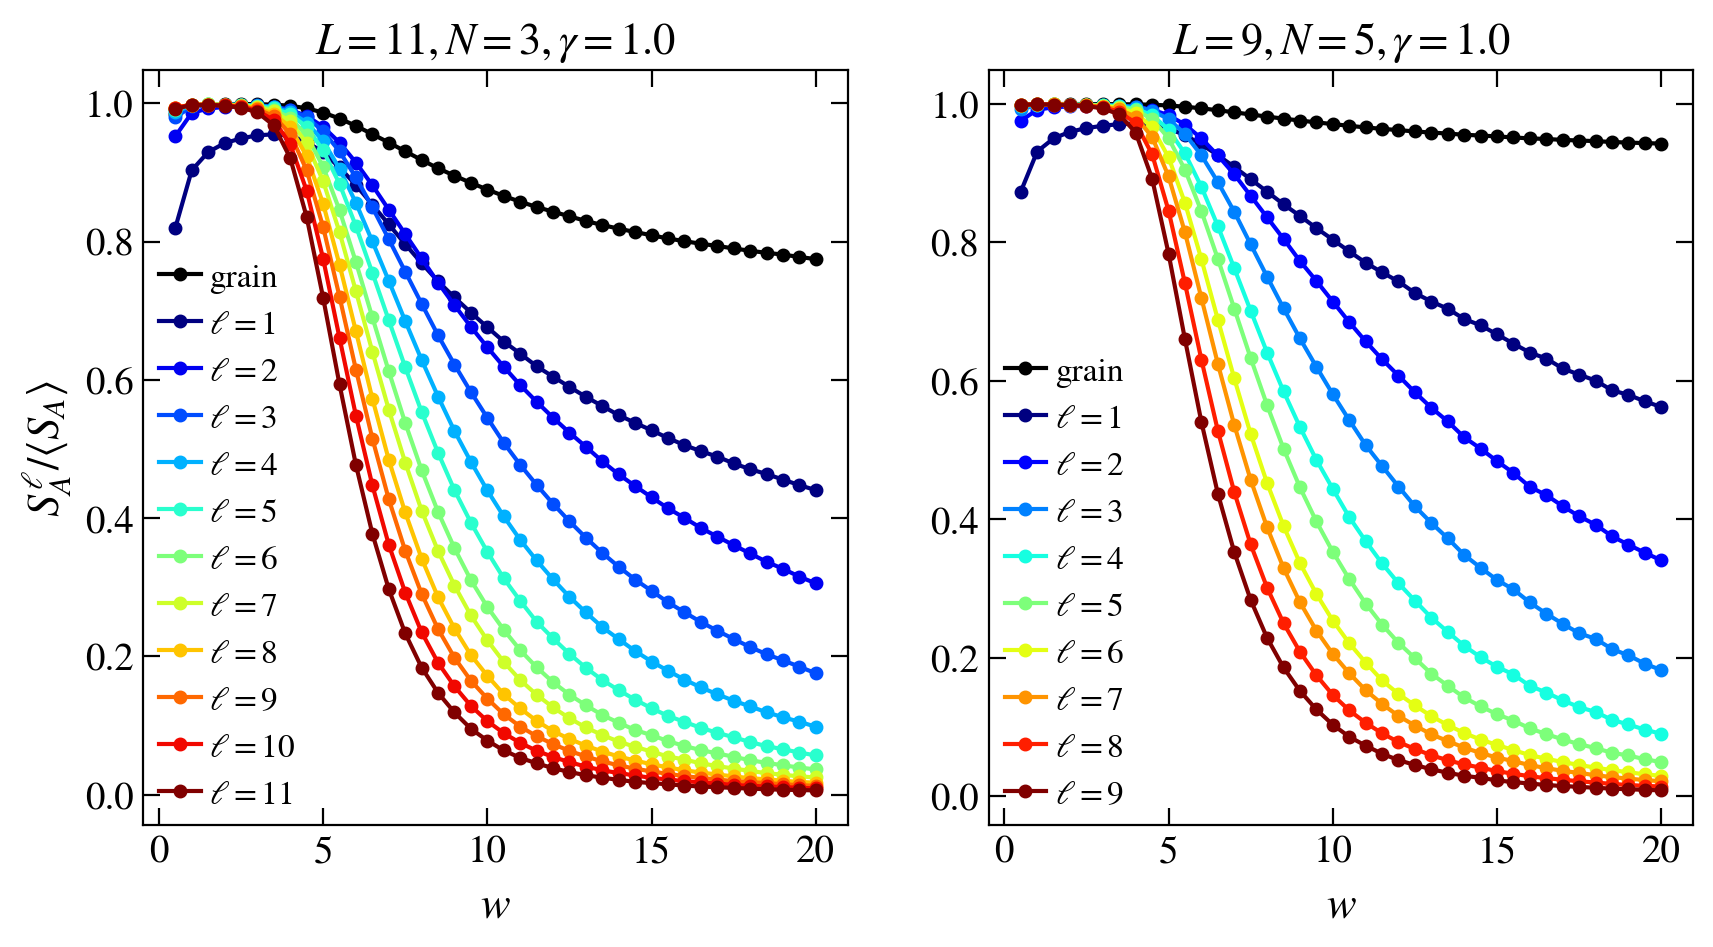

In [61]:
L_total=14
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0

w_vals = [10.0]
if config_disorder and config_disorder_sorted:
    w_vals = np.linspace(1.0, 4.9, 40)
    w_vals = np.round(10**w_vals, 5)
elif config_disorder:
    w_vals = np.linspace(0.5, 35.0, 70)
else:   
    w_vals = np.linspace(0.5, 20.0, 40)

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200)


nu = 500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

folder_base = f'./collected data/'
folder = folder_base + base_dir[3:] + f"nu={nu}/"
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)


for idx1, N in enumerate([3, 5]):
    L = L_total - N
    sub_sizes = np.arange(0, L_total + 1)
    name_out = folder + f'_L={L},N={N},gamma={gamma},alfa={alfa}.hdf5'

    if exists(name_out):
        with h5py.File(name_out, "r") as file:
            w_vals       = np.array(file.get('disorder'))
            gap_ratio    = np.array(file.get('gap_ratio'))
            entropy      = np.array(file.get('entropy'))
            entropy_site = np.array(file.get('single_site_entropy'))
    else:
        print(name_out)
        
    colors = plt.cm.jet(np.linspace(0, 1, sub_sizes.size-N-1))
    for ell in sub_sizes[N-1 : -1]:
        ydata = entropy_site[ell] / page(1, L_total - 1)
        axis[idx1].plot(w_vals, ydata, marker='o', markersize=4, label=r"$\ell=%d$"%(ell - N + 1) if ell >= N else "grain", color=colors[ell-N] if ell >= N else 'black')
        #axis.plot(w_vals, gap_ratio, marker='o', label=r"$L=%d$"%L)
        #axis[idx1].set_ylim(0,1)
        #axis[idx1].set_xlim(0, None)
fig_help.set_plot_elements(axis[0], ylabel=r"$S^{\ell}_A / \langle S_A\rangle$", xlabel=r"$w$", font_size=14, set_legend=False)
fig_help.set_plot_elements(axis[1], ylabel="", xlabel=r"$w$", font_size=14, set_legend=False)


axis[0].set_title(r"$L=%d, N=3, \gamma=%.1f$"%(L_total - 3,gamma), fontsize=16)
axis[1].set_title(r"$L=%d, N=5, \gamma=%.1f$"%(L_total - 5,gamma), fontsize=16)
axis[0].legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,-0.02))
axis[1].legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,-0.02))
fig.subplots_adjust(wspace = 0.2, hspace=0.05)

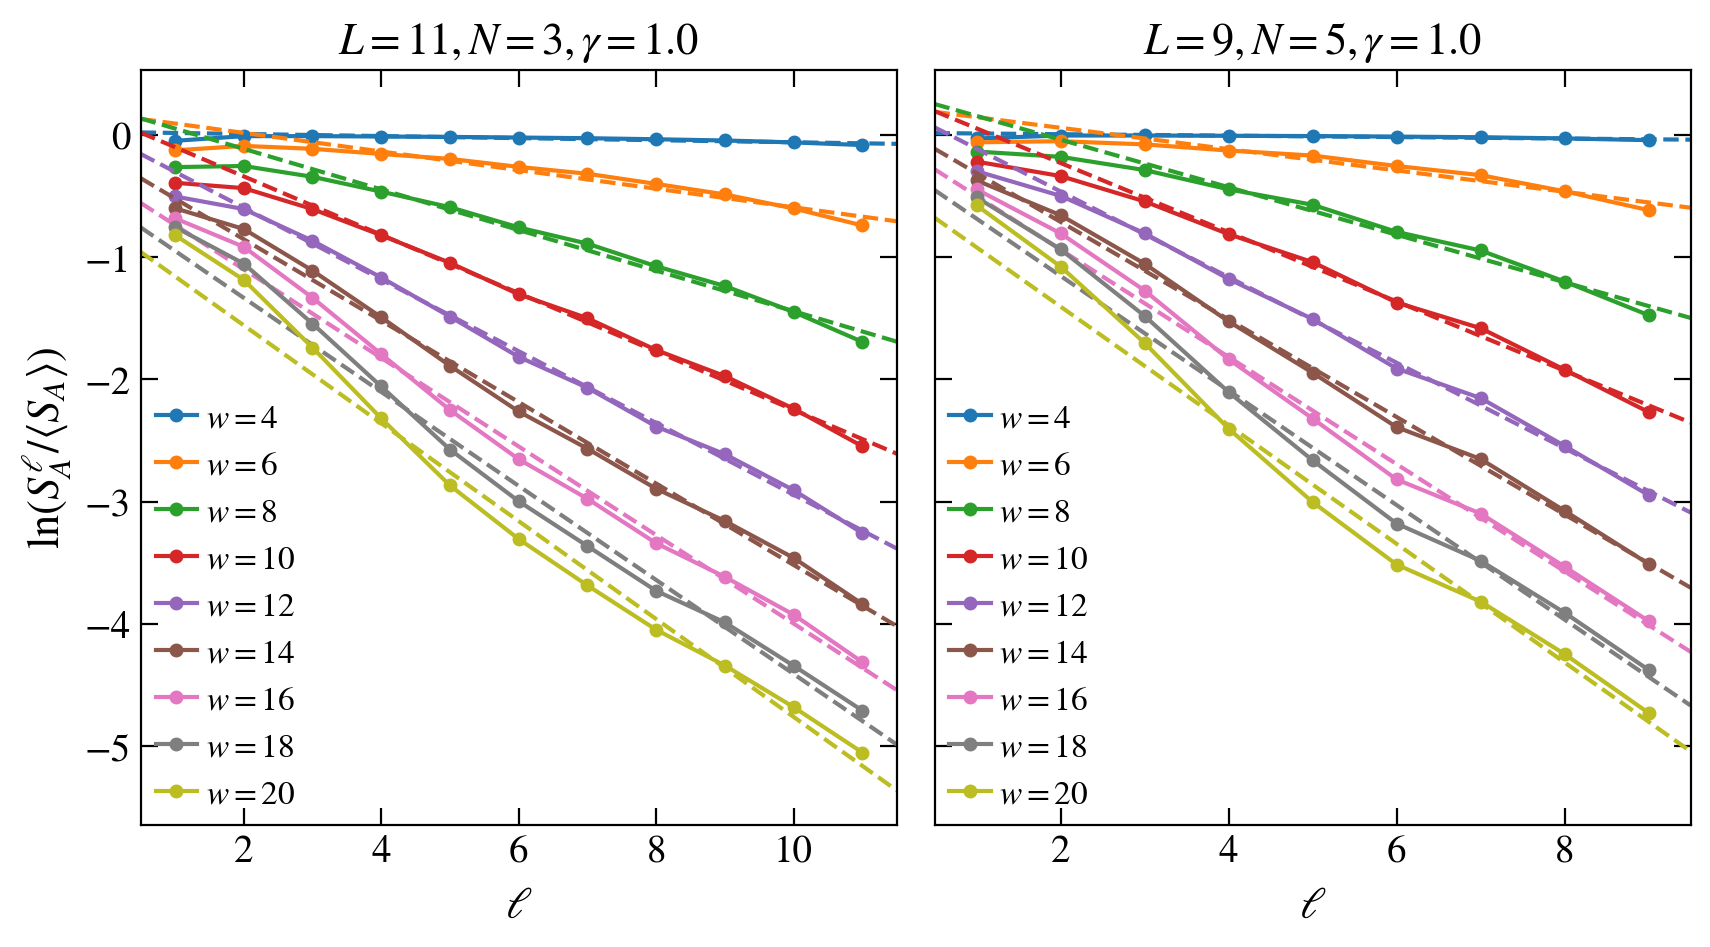

In [59]:
L_total=14
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0


wx = [10.0]
if config_disorder and config_disorder_sorted:
    wx = np.linspace(1.0, 4.5, 8)
    wx = np.round(10**w_vals, 5)
else:   
    wx = np.arange(4, 21, 2)

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200, sharey=True)

def frac(dim):
    return 200#0.25 * dim

for idx1, N in enumerate([3, 5]):
    sub_sizes = np.arange(N, L_total)

    L = L_total - N
    colors = plt.cm.jet(np.linspace(0, 1, sub_sizes.size - 2))

    name_out = folder + f'_L={L},N={N},gamma={gamma},alfa={alfa}.hdf5'
    if exists(name_out):
        with h5py.File(name_out, "r") as file:
            w_vals       = np.array(file.get('disorder'))
            gap_ratio    = np.array(file.get('gap_ratio'))
            entropy      = np.array(file.get('entropy'))[N:-1]
            entropy_site = np.array(file.get('single_site_entropy'))[N:-1]
    else:
        print(name_out)
    for ii, w in enumerate(wx):
        idx = list(w_vals).index(w)
        
        xdata = sub_sizes - N + 1
        ydata = np.log(np.transpose(entropy_site)[idx] / page(1, L_total - 1))
        plo = axis[idx1].plot(xdata, ydata, marker='o', markersize=4, label=legend_label("w", w))
        pars, pconv = fit(lin_fit,
                        xdata = xdata[2:],
                        ydata = ydata[2:])
        xdata = np.linspace(0.5, L_total - N + 0.5, 100)
        axis[idx1].plot(xdata, lin_fit(xdata, *pars), ls='--', color=plo[0].get_color())
        xi = pars[0]
        # print(xi)
        axis[idx1].set_xlim(min(xdata), max(xdata))
    fig_help.set_plot_elements(axis[idx1], ylabel=r"$\ln (S^{\ell}_A / \langle S_A\rangle)$" if idx1 == 0 else "", xlabel=r"$\ell$", font_size=14, set_legend=not idx1, yscale='linear')


axis[0].set_title(r"$L=%d, N=3, \gamma=%.1f$"%(L_total - 3,gamma), fontsize=16)
axis[1].set_title(r"$L=%d, N=5, \gamma=%.1f$"%(L_total - 5,gamma), fontsize=16)
axis[0].legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,-0.02))
axis[1].legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,-0.02))
fig.subplots_adjust(wspace = 0.05, hspace=0.05)

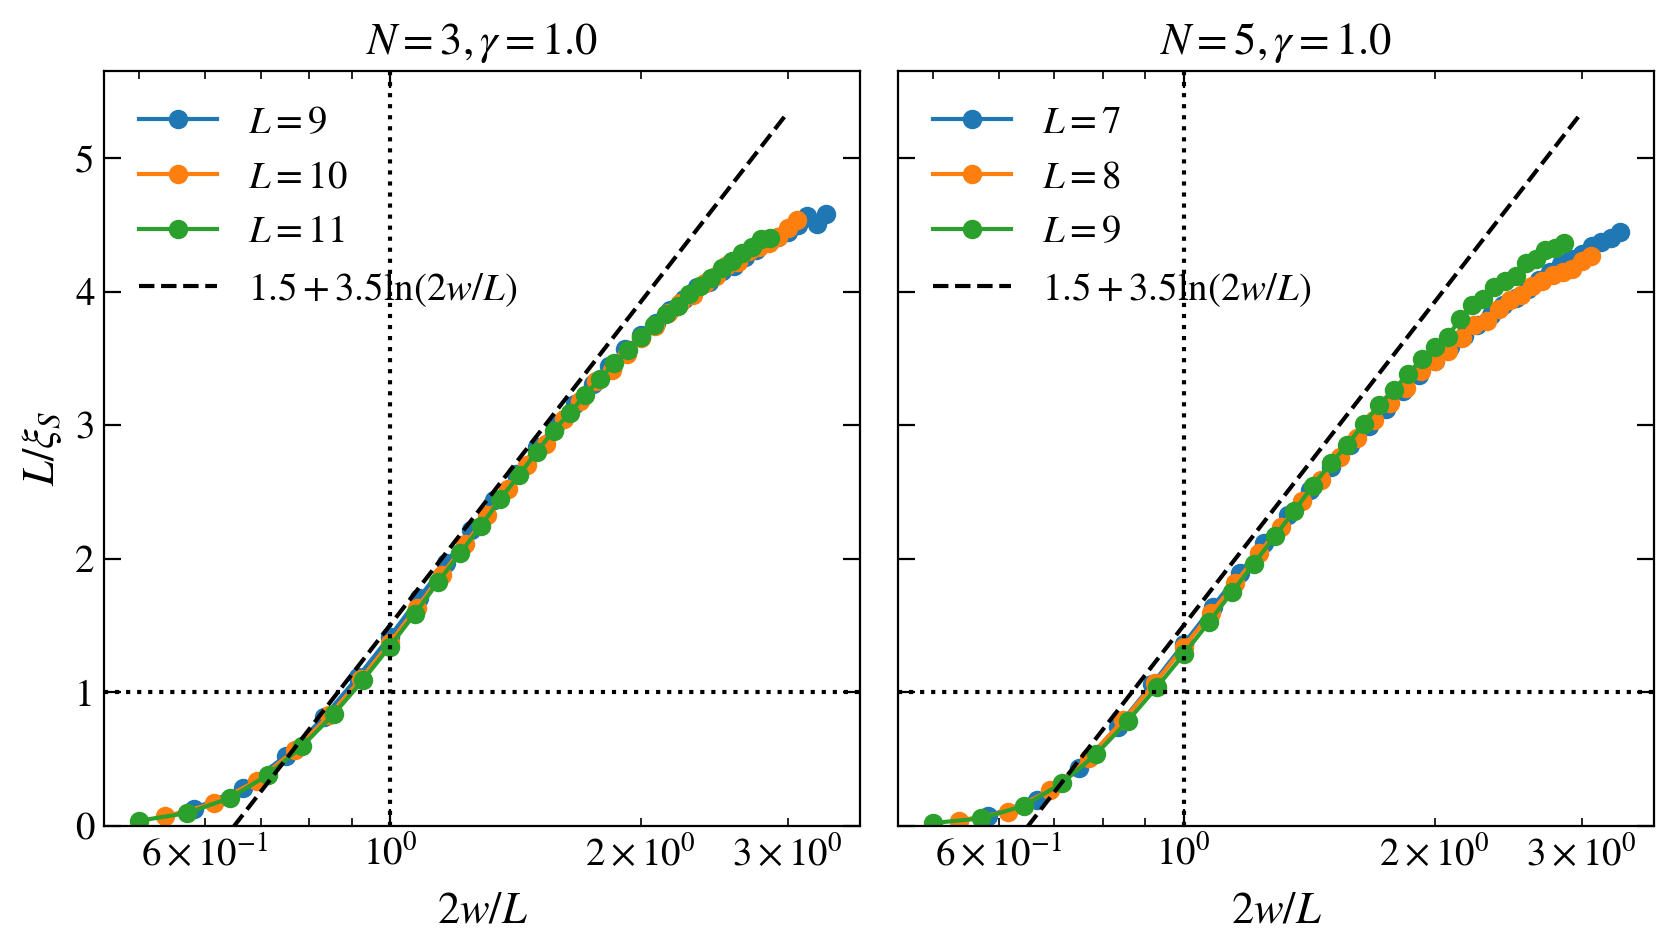

In [111]:
L_total=16
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0


w_vals = [10.0]
if config_disorder and config_disorder_sorted:
    w_vals = np.linspace(1.0, 4.9, 40)
    w_vals = np.round(10**w_vals, 5)
elif config_disorder:
    w_vals = np.linspace(0.5, 35.0, 70)
else:   
    w_vals = np.linspace(3.0, 20.5, 34)

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200, sharey=True)

nu = 500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

folder_base = f'./collected data/'
folder = folder_base + base_dir[3:] + f"nu={nu}/"

def rescale_xi(xi):
    return ( 1/xi )

for idx1, N in enumerate([3, 5]):
    for L_total in np.arange(12, 15, 1):
        sub_sizes = np.arange(N, L_total)

        L = L_total - N
        name_out = folder + f'_L={L},N={N},gamma={gamma},alfa={alfa}.hdf5'
        if exists(name_out):
            with h5py.File(name_out, "r") as file:
                w_vals       = np.array(file.get('disorder'))
                gap_ratio    = np.array(file.get('gap_ratio'))
                entropy_tmp      = np.array(file.get('entropy'))[N:-1]
                entropy_site_tmp = np.array(file.get('single_site_entropy'))[N:-1]
                size = len(entropy_tmp)
                entropy = np.zeros((sub_sizes.size, 34))
                entropy_site = np.zeros((sub_sizes.size, 34))
                for ii in range( size ):
                    entropy[ii] = entropy_tmp[ii][w_vals > 3.0]
                    entropy_site[ii] = entropy_site_tmp[ii][w_vals > 3.0]
                w_vals = w_vals[w_vals > 3.0]
        else:
            print(name_out)
        colors = plt.cm.jet(np.linspace(0, 1, sub_sizes.size - 2))
        corr_len = np.zeros(w_vals.shape)
        for ii, w in enumerate(w_vals):
            
            xdata = sub_sizes - N + 1
            ydata = np.log(np.transpose(entropy_site)[ii] / page(1, L_total - 1))
            # print(ydata)
            # plo = axis[idx1].plot(xdata, ydata, marker='o', markersize=4, label=legend_label("w", w))
            pars, pconv = fit(lin_fit,
                            xdata = xdata[2:],
                            ydata = ydata[2:])
            # axis[idx1].plot(xdata, lin_fit(xdata, *pars), ls='--', color=plo[0].get_color())
            xi = pars[0]
            corr_len[ii] = xi
        
        axis[idx1].plot(2 * w_vals / (L+N), rescale_xi( corr_len / L ), label=r"$L=%d$"%L, marker='o')

    axis[idx1].axhline(y=1.0, ls=':', c='k')
    axis[idx1].axvline(x=1.0, ls=':', c='k')

    xxx = np.linspace(0.5, 3, 100)
    axis[idx1].plot(xxx, 1.5 + 3.5*np.log(xxx), ls='--', c='k', label=r"$1.5+3.5\ln(2w/L)$")
    
    fig_help.set_plot_elements(axis[idx1], ylabel=r"$L/\xi_S$" if idx1 == 0 else "", xlabel=r"$2w/L$", font_size=14, set_legend=True, yscale='linear', xscale='log')
    axis[idx1].set_ylim(0, None)
    
axis[0].set_title(r"$N=3, \gamma=%.1f$"%(gamma), fontsize=16)
axis[1].set_title(r"$N=5, \gamma=%.1f$"%(gamma), fontsize=16)
# axis[0].legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,-0.02))
# axis[1].legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,-0.02))
fig.subplots_adjust(wspace = 0.05, hspace=0.05)

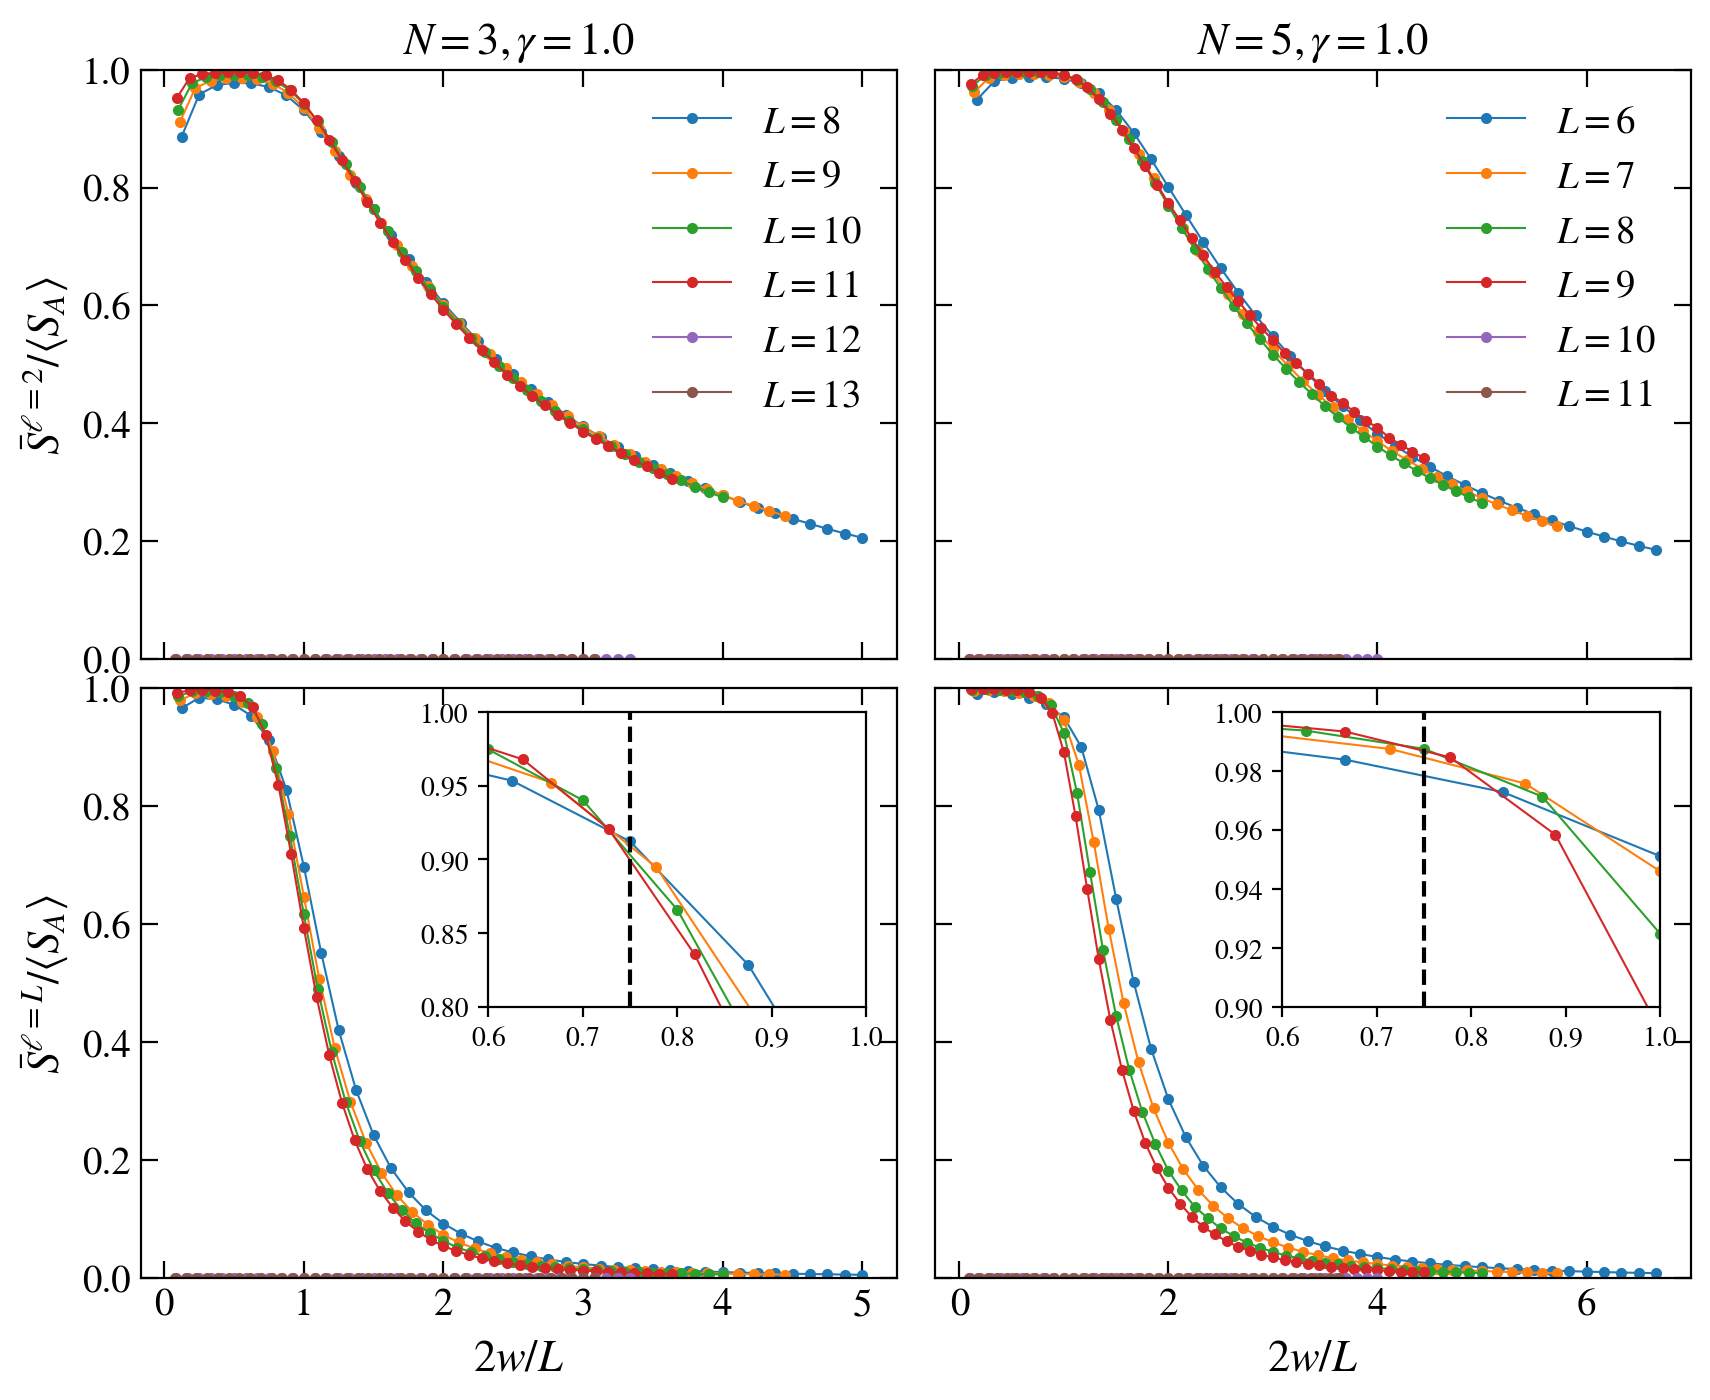

In [86]:
L_total=15
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

w_vals = [10.0]
if config_disorder and config_disorder_sorted:
    w_vals = np.linspace(1.0, 4.9, 40)
    w_vals = np.round(10**w_vals, 5)
elif config_disorder:
    w_vals = np.linspace(0.5, 35.0, 70)
else:   
    w_vals = np.linspace(0.5, 20.0, 40)

sub_sizes = np.arange(0, L+1)
fig, axis = plt.subplots( nrows=2, ncols=2, figsize=(10,8), dpi = 200, sharey=True)


nu = 500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

folder_base = f'./collected data/'
folder = folder_base + base_dir[3:] + f"nu={nu}/"

inset = []
inset.append( axis[1][0].inset_axes([0.46, 0.46, 0.5, 0.5]) )
inset.append( axis[1][1].inset_axes([0.46, 0.46, 0.5, 0.5]) )
for idx1, N in enumerate([3, 5]):
    for L_total in np.arange(11, 17):
        L = L_total - N
        name_out = folder + f'_L={L},N={N},gamma={gamma},alfa={alfa}.hdf5'
        if exists(name_out):
            with h5py.File(name_out, "r") as file:
                w_vals       = np.array(file.get('disorder'))
                gap_ratio    = np.array(file.get('gap_ratio'))
                entropy      = np.array(file.get('entropy'))
                entropy_site = np.array(file.get('single_site_entropy'))
        else:
            print(name_out)
        for idx2, ell in enumerate([N+1, L_total-1]):
            axis[idx2][idx1].plot(2/(L) * w_vals, entropy_site[ell] / page(1, L_total - 1), marker='o', markersize=3, lw=0.75, label=r"$L=%d$"%L)
            axis[idx2][idx1].set_ylim(0, 1)
            if idx2 == 1:
                inset[idx1].plot(2/(L) * w_vals, entropy_site[ell] / page(1, L_total - 1), marker='o', markersize=3, lw=0.75)
                
            # axis[idx2][idx1].set_xlim(0, 3.0)
fig_help.set_plot_elements(axis[1][0], ylabel=r"$\bar{S}^{\ell=L} / \langle S_A\rangle$", xlabel=r"$2w/L$", font_size=14, set_legend=False, yscale='linear', xscale='linear')
fig_help.set_plot_elements(axis[1][1], ylabel=r"", xlabel=r"$2w/L$", font_size=14, set_legend=False, yscale='linear', xscale='linear')
fig_help.set_plot_elements(axis[0][0], ylabel=r"$\bar{S}^{\ell=2} / \langle S_A\rangle$", xlabel="",         font_size=14, set_legend=True, yscale='linear', xscale='linear')
fig_help.set_plot_elements(axis[0][1], ylabel=r"", xlabel="",         font_size=14, set_legend=True, yscale='linear', xscale='linear')

inset[0].set_ylim(0.8, 1)
inset[0].set_xlim(0.6, 1.0)
inset[0].axvline(x=0.75, ls='--', c='k')

inset[1].set_ylim(0.9, 1)
inset[1].set_xlim(0.6, 1.)
inset[1].axvline(x=0.75, ls='--', c='k')

axis[0][0].set_title(r"$N=3, \gamma=%.1f$"%(gamma), fontsize=16)
axis[0][1].set_title(r"$N=5, \gamma=%.1f$"%(gamma), fontsize=16)
# axis[0][1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
# axis[1][1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
axis[0][1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
axis[0][0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
fig.subplots_adjust(wspace = 0.05, hspace=0.05)

## COLLAPSE

In [154]:
N=5
gamma=1.0
alfa=1.0
critfun='free'
ansatz='classic'

for critfun in ['free', 'lin', 'power_law']:
    for ansatz in ['classic', 'RG', 'KT']:
        for nejm in ["GapRatio", "Entropy_p=1"]:
            critical_points = []
            nus = []
            CF = []

            filename = f"{nejm},N={N},gamma={gamma},alfa={alfa}_critfun=%s_ansatz=%s"%(critfun, ansatz)
            dirname = './CriticalParameters/'
            for files in os.listdir(dirname + 'raw/'):
                if files.startswith(filename):
                    # print(files)  # printing file name of desired extension
                    with h5py.File(dirname + 'raw/' + files, "r") as file:
                        nus.append( np.array(file.get('crit exp')) )
                        critical_points.append( np.array(file.get('crit_pars')) )
                        CF.append( np.array(file.get('costfun')) )
                else:
                    continue

            # print(critical_points)
            CF = np.array(CF)
            nus = np.array(nus)
            critical_points = np.array(critical_points)
            print(CF)
            hf = h5py.File(dirname + filename + '.hdf5', 'w')
            hf.create_dataset('crit_pars', critical_points.shape,   data = critical_points)
            hf.create_dataset('crit exp',  nus.shape,               data = nus)
            hf.create_dataset('costfun',   CF.shape,                data = CF)
            hf.close()

[0.70236366 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366
 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366
 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366
 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366
 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366
 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366
 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366
 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366
 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366
 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366
 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366
 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366
 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366
 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366
 0.70236366 0.70236366 0.70236366 0.70236366 0.70236366 0.7023

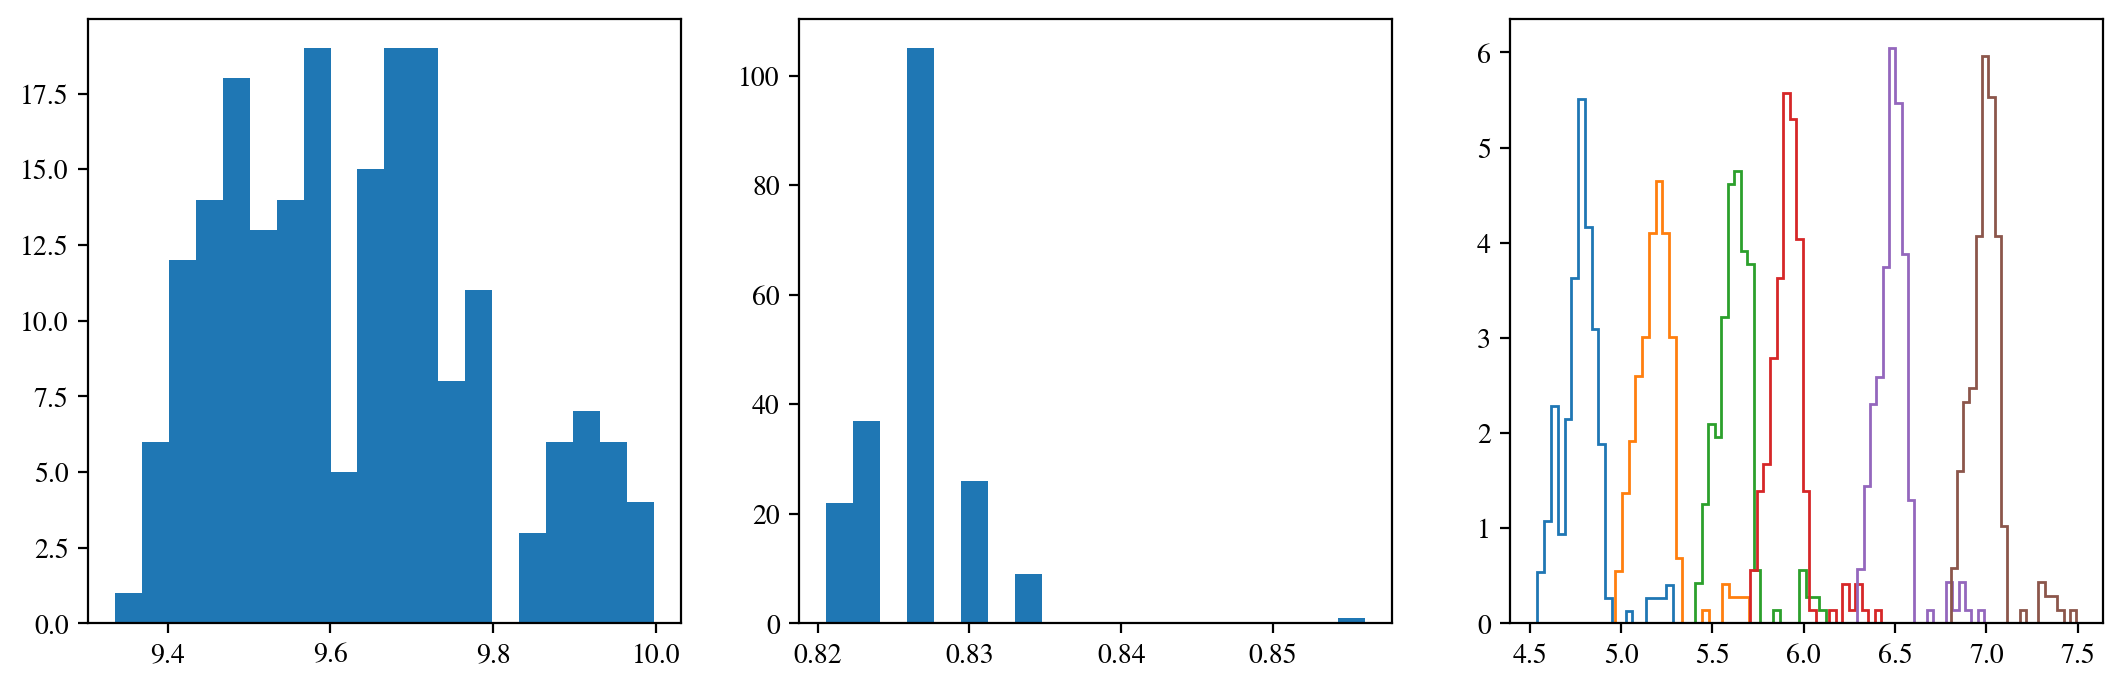

In [155]:
N=5
gamma=1.0
alfa=1.0

critfun='free'
ansatz='KT'
# nejm = "GapRatio"
nejm = "Entropy_p=1"
filename = f"CriticalParameters/{nejm},N={N},gamma={gamma},alfa={alfa}_critfun=%s_ansatz=%s.hdf5"%(critfun, ansatz)

if exists(filename):
    with h5py.File(filename, "r") as file:
        crit_pars   = np.transpose(np.array(file.get('crit_pars')))
        crit_exp    = np.array(file.get('crit exp'))
        CF          = np.array(file.get('costfun'))
    
fig, axis = plt.subplots( nrows=1, ncols=3 + int(not critfun == 'free'), figsize=(13,4), dpi = 200)
axis[0].hist(crit_exp, bins=20)
axis[1].hist(CF, bins=20)

sizes = np.arange(11, 17, 1)
if critfun == 'free':
    for ii in range(len(sizes)):
        hist, edges = np.histogram(crit_pars[ii], bins=20, normed=True)
        axis[2].stairs(hist, edges)
else:
    for ii in range(len(crit_pars)):
        hist, edges = np.histogram(crit_pars[ii], bins=20, normed=True)
        axis[2+ii].stairs(hist, edges)

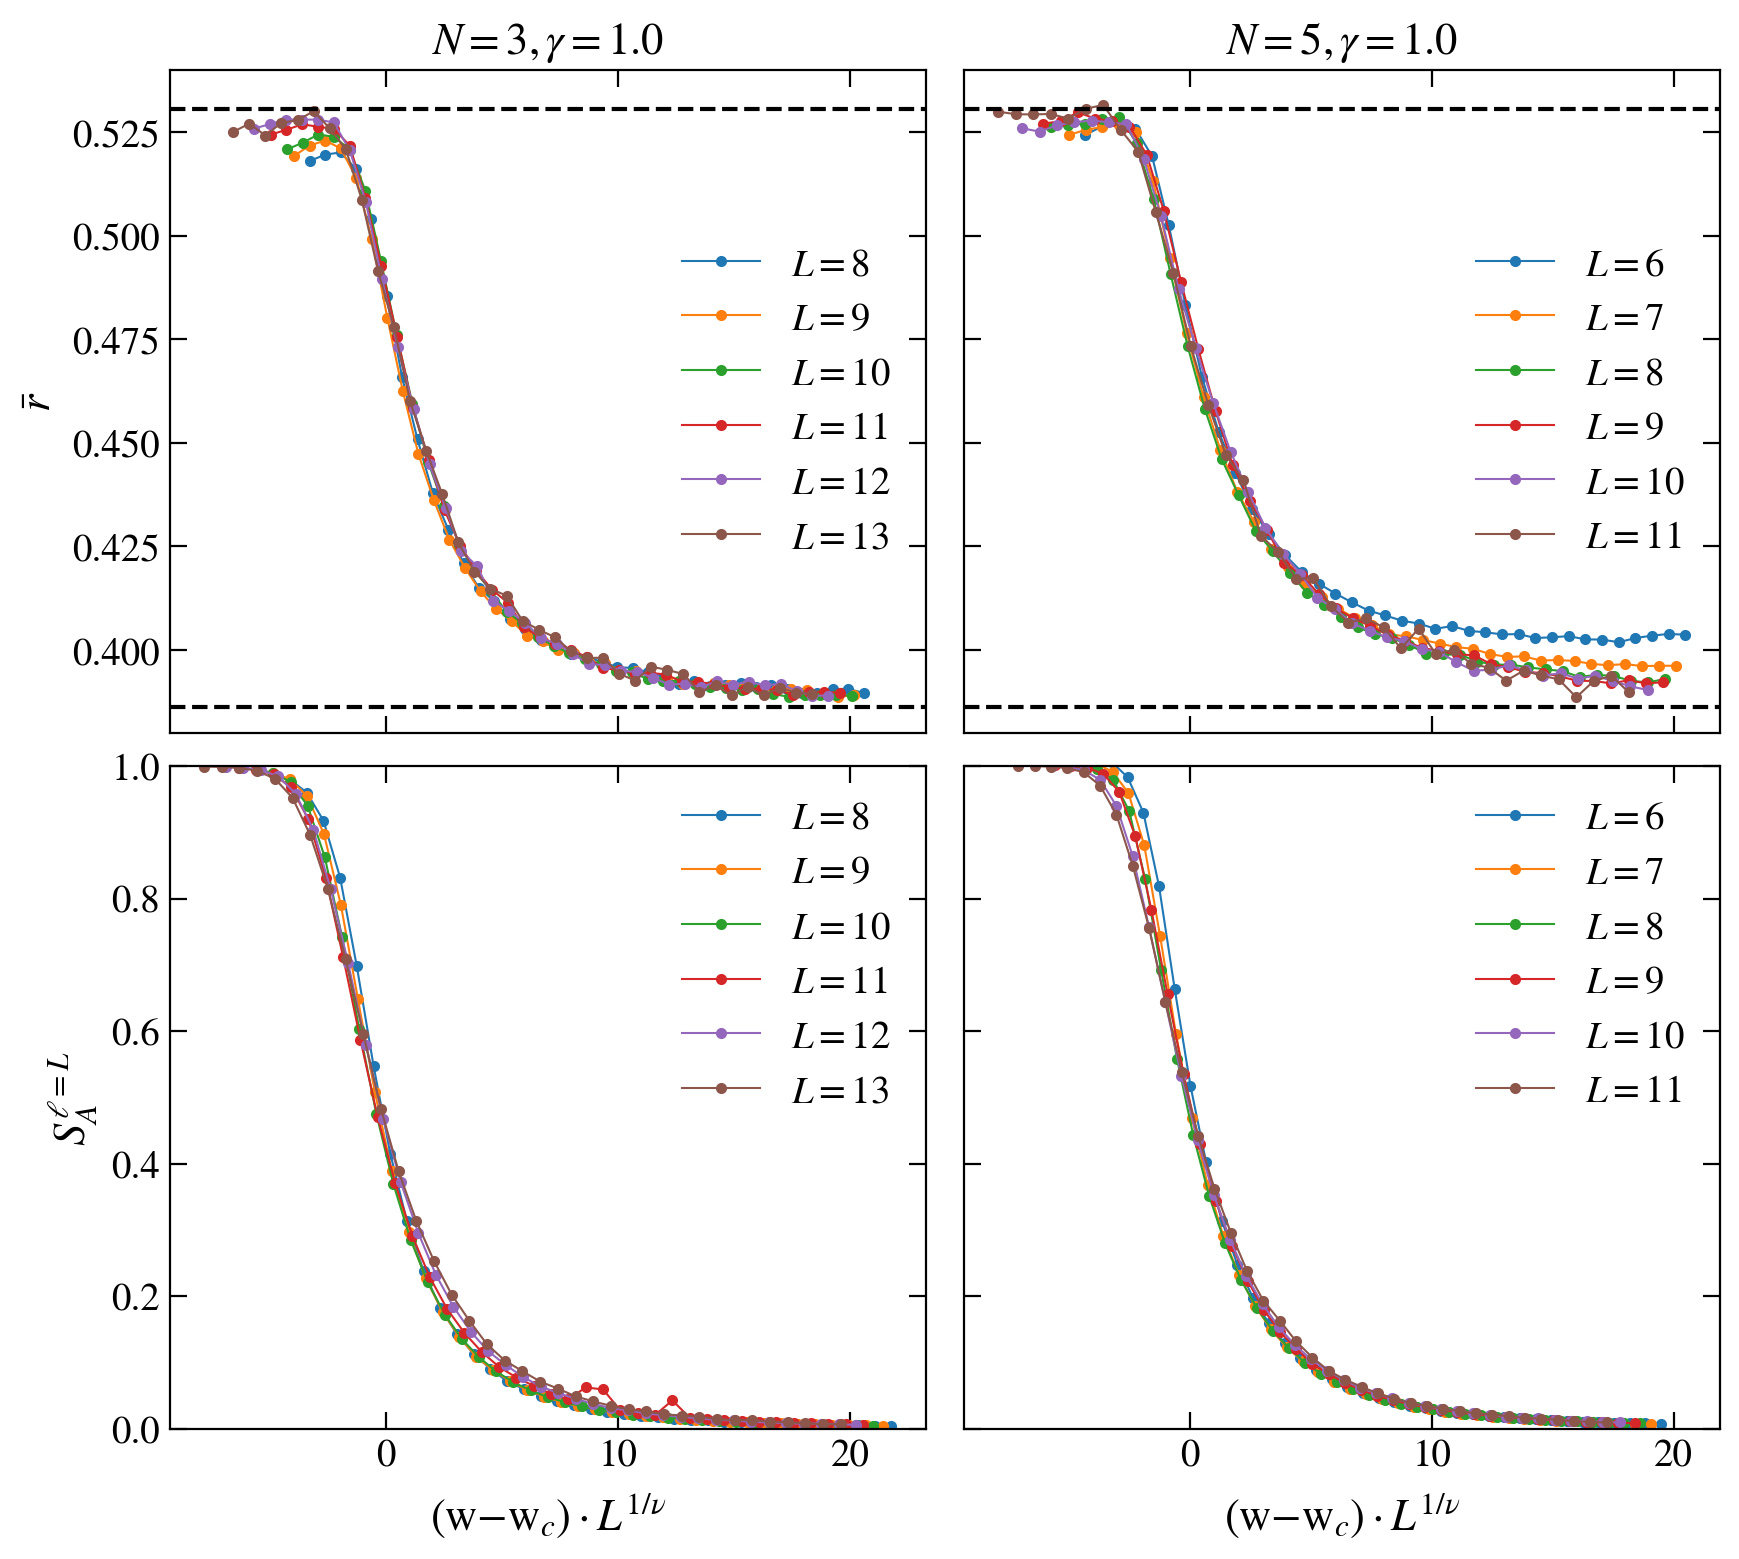

In [158]:
L_total=15
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N


plot_gaps = 1

b = 1.5

w_vals = [10.0]
if config_disorder and config_disorder_sorted:
    w_vals = np.linspace(1.0, 4.9, 40)
    w_vals = np.round(10**w_vals, 5)
elif config_disorder:
    w_vals = np.linspace(0.5, 35.0, 70)
else:   
    w_vals = np.linspace(2.0, 20.0, 37)

sub_sizes = np.arange(0, L+1)
fig, axis = plt.subplots( nrows=2, ncols=2, figsize=(10,9), dpi = 200, sharey='row', sharex='col')

sizes = np.arange(11, 17, 1)

rescale = 0
r_min = 0.32
nu = 500
frac = lambda dim: int(dim * nu) if nu <= 1.0 else nu

folder_base = f'./collected data/'
folder = folder_base + base_dir[3:] + f"nu={nu}/"
os.makedirs(folder_base, exist_ok=True)
os.makedirs(folder, exist_ok=True)

if rescale:
    if config_disorder and config_disorder_sorted:
        xlab = r"$w / 2^L$"
    else:
        xlab = r"$2w / L$"
else:
    xlab = r"$w$"
    

critfun='free'
ansatz='classic'

rescale_fun = cost.resc_functions_dict[ansatz]
critical_fun = cost.crit_functions_dict[critfun]
xlab = r"$%s$"%cost.scale_ansatz_label[ansatz](xlab)

for idx1, N in enumerate([3, 5]):
    
    disorder = []
    gaps = []
    S_p1 = []
    for L_total in sizes:
        sub_sizes = np.arange(0, L_total+1)
        L = L_total - N
        LA = L_total // 2
        name_out = folder + f'_L={L},N={N},gamma={gamma},alfa={alfa}.hdf5'

        if exists(name_out):
            with h5py.File(name_out, "r") as file:
                w_vals       = np.array(file.get('disorder'))
                gap_ratio    = np.array(file.get('gap_ratio'))
                entropy      = np.array(file.get('entropy'))
                entropy_site = np.array(file.get('single_site_entropy'))
        else:
            print(name_out)

        if rescale:
            if config_disorder and config_disorder_sorted:
                wx = w_vals / np.exp(L*np.log(2)) 
            else: 
                wx = 2 * w_vals / L**b
        else:
            wx = w_vals
        
        disorder.append(wx[gap_ratio > r_min])
        S_p1.append(entropy_site[-2][gap_ratio > r_min] / page(1, L-1))
        gaps.append(gap_ratio[gap_ratio > r_min])

    filename = f"CriticalParameters/GapRatio,N={N},gamma={gamma},alfa={alfa}_critfun=%s_ansatz=%s.hdf5"%(critfun, ansatz)
    if exists(filename):
        with h5py.File(filename, "r") as file:
            crit_pars   = np.transpose(np.array(file.get('crit_pars')))
            crit_exp    = np.array(file.get('crit exp'))
            CF          = np.array(file.get('costfun'))
    else:
        print(filename)
    criticals = np.zeros( (len(crit_pars)) )
    for ii in range(len(crit_pars)):
        criticals[ii] = np.median(crit_pars[ii])

    for ii, L in enumerate(sizes - N):
        axis[0][idx1].plot(rescale_fun(disorder[ii], sizes, ii, critical_fun, np.median(crit_exp), *criticals), gaps[ii], marker='o', markersize=3, lw=0.75, label=r"$L=%d$"%L)
        
    filename = f"CriticalParameters/Entropy_p=1,N={N},gamma={gamma},alfa={alfa}_critfun=%s_ansatz=%s.hdf5"%(critfun, ansatz)
    if exists(filename):
        with h5py.File(filename, "r") as file:
            crit_pars   = np.transpose(np.array(file.get('crit_pars')))
            crit_exp    = np.array(file.get('crit exp'))
            CF          = np.array(file.get('costfun'))
    else:
        print(filename)
    for ii in range(len(crit_pars)):
        criticals[ii] = np.median(crit_pars[ii])
    for ii, L in enumerate(sizes - N):
        axis[1][idx1].plot(rescale_fun(disorder[ii], sizes, ii, critical_fun, np.median(crit_exp), *criticals), S_p1[ii], marker='o', markersize=3, lw=0.75, label=r"$L=%d$"%L)
        # axis[idx1].plot(rescale_fun(disorder[ii], sizes, ii, critical_fun, par, *crit_pars), gaps[ii], ls='--', marker='o', label=r"$L=%d$"%(L))

    axis[0][idx1].axhline(y=0.3863, ls='--', color='black')
    axis[0][idx1].axhline(y=0.5307, ls='--', color='black')
    
    axis[0][idx1].set_ylim(0.38,0.54)
    axis[1][idx1].set_ylim(0.0,1.0)
    # axis[0][idx1].set_xlim(-1e5, 10)
    # axis[1][idx1].set_xlim(-1e5, 10)
    
        
    # if not config_disorder: axis[idx1].set_xlim(0, None)
    #         # axis[idx2][idx1].set_xlim(0.0,2)

fig_help.set_plot_elements(axis[0][0], ylabel=r"$\bar{r}$", xlabel="", font_size=14, set_legend=True)
fig_help.set_plot_elements(axis[0][1], ylabel="", xlabel="", font_size=14, set_legend=True)
fig_help.set_plot_elements(axis[1][0], ylabel=r"$S^{\ell=L}_A$", xlabel=xlab, font_size=14, set_legend=True)
fig_help.set_plot_elements(axis[1][1], ylabel="", xlabel=xlab, font_size=14, set_legend=True)

if config_disorder and config_disorder_sorted:
    for ax in axis.flatten():
        ax.set_xscale('log')


axis[0][0].set_title(r"$N=3, \gamma=%.1f$"%(gamma), fontsize=16)
axis[0][1].set_title(r"$N=5, \gamma=%.1f$"%(gamma), fontsize=16)

fig.subplots_adjust(wspace = 0.05, hspace=0.05)

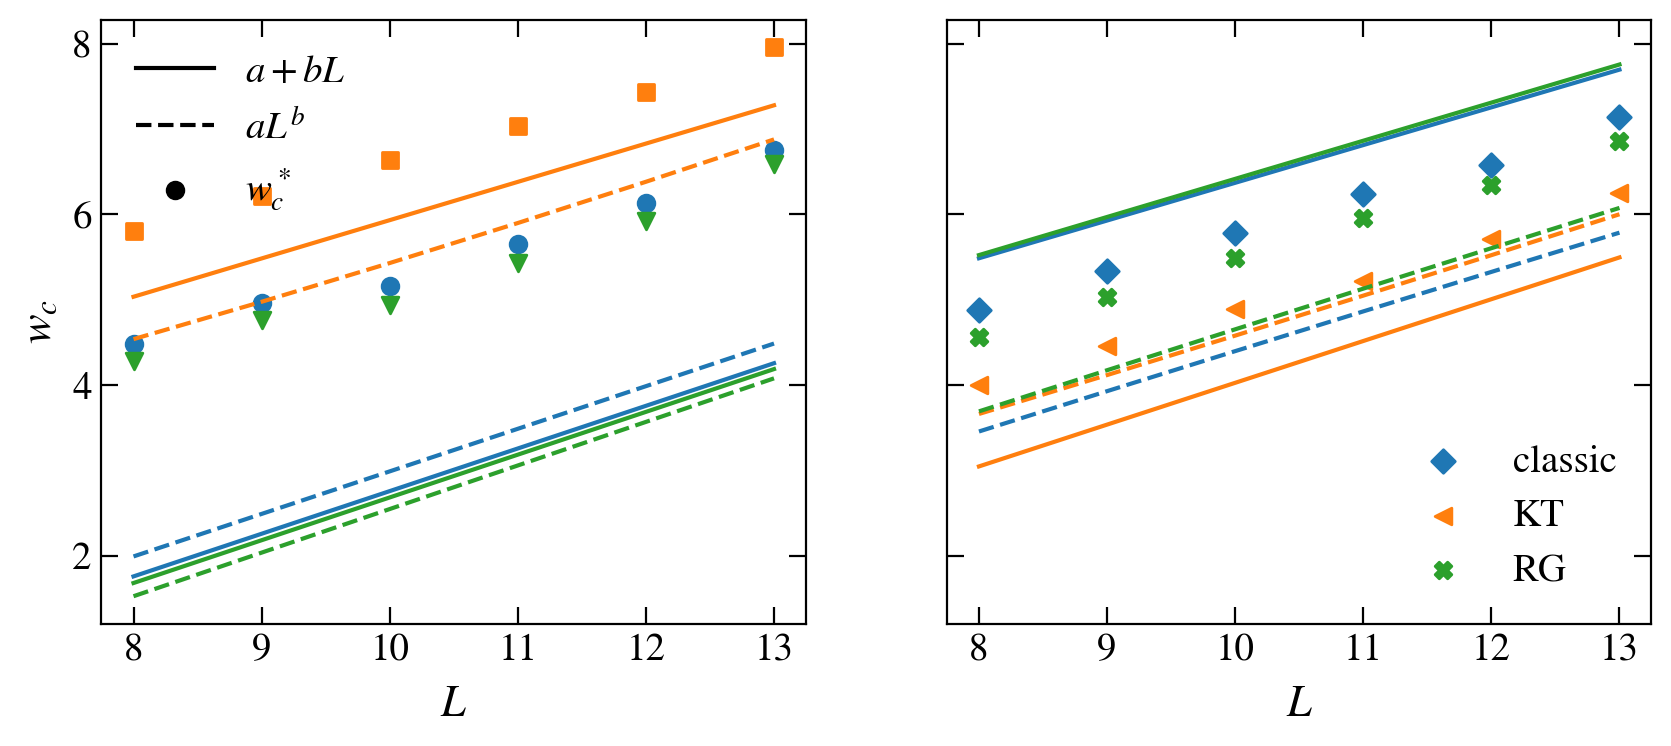

In [153]:
fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,4), dpi = 200, sharey=True)
N = 3
alfa=1.0
gamma=1.0

sizes = np.arange(11, 17, 1) - N
linestyle = itertools.cycle(linestyle_ls)
markers = itertools.cycle(markers_ls)
lss = ['-', '--', ':']
axis[0].scatter(np.nan, np.nan, color='k', marker='o', label=r'$w_c^*$')
axis[0].plot(np.nan, np.nan, color='k', ls = '-', label=r'$a+bL$')
axis[0].plot(np.nan, np.nan, color='k', ls = '--', label=r'$aL^b$')
for bca, nejm in enumerate(['GapRatio', 'Entropy_p=1']):

    for aa, critfun in enumerate(['free', 'lin', 'power_law']):
        colors_ls_cyc = itertools.cycle(colors_ls)

        critical_fun = cost.crit_functions_dict[critfun]
        for ansatz in ['classic', 'KT', 'RG']:
            filename = f"CriticalParameters/{nejm},N={N},gamma={gamma},alfa={alfa}_critfun=%s_ansatz=%s.hdf5"%(critfun, ansatz)
            if exists(filename):
                with h5py.File(filename, "r") as file:
                    crit_pars   = np.transpose(np.array(file.get('crit_pars')))
                    crit_exp    = np.array(file.get('crit exp'))
                    CF          = np.array(file.get('costfun'))
            else:
                print(filename)
            criticals = np.zeros( (len(crit_pars)) )
            for ii in range(len(crit_pars)):
                criticals[ii] = np.median(crit_pars[ii])
            if critfun == 'free':   
                axis[bca].scatter(sizes, criticals, color=next(colors_ls_cyc), marker=next(markers), label=ansatz if bca else '')
            else:
                wc = np.zeros( (sizes.size) )
                for ii, L in enumerate(sizes):
                    wc[ii] = critical_fun(sizes, ii, *criticals)       
                axis[bca].plot(sizes, wc, color=next(colors_ls_cyc), ls = lss[aa-1])
                

fig_help.set_plot_elements(axis[0], ylabel=r"$w_c$", xlabel=r"$L$", font_size=14, set_legend=True)
fig_help.set_plot_elements(axis[1], ylabel="", xlabel=r"$L$", font_size=14, set_legend=True)

## PARTICIPATION RATIO

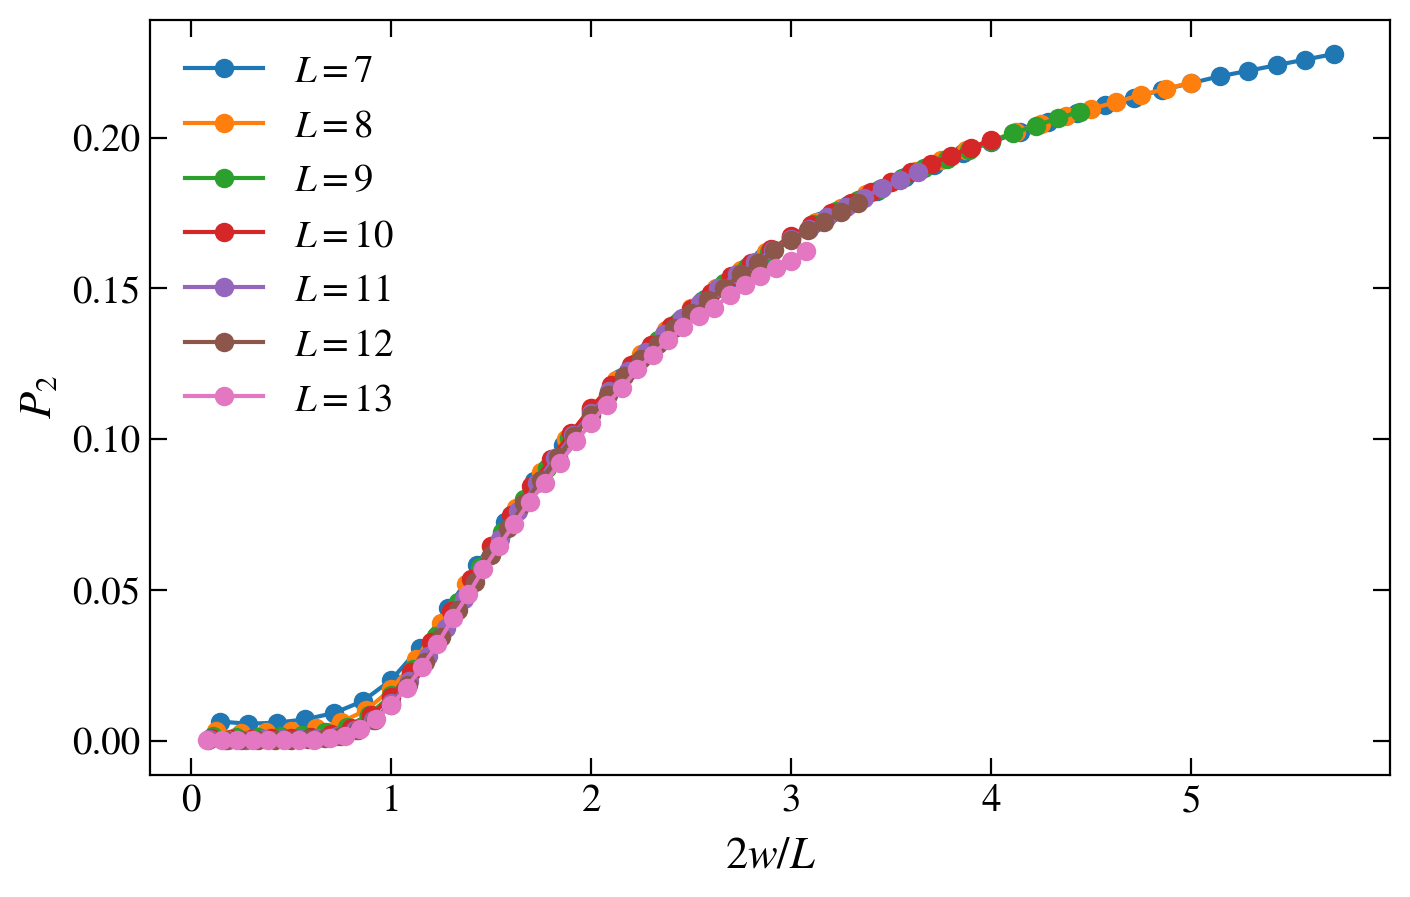

In [71]:

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(8,5), dpi = 200)

L_total=16
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0

qs = np.linspace(0.1, 2.0, 20)
w_vals = np.linspace(0.5, 20.0, 40)
sizes = np.arange(10, 17) - N

participation = np.zeros((w_vals.size))

q = 2

q_idx = (np.round(qs, 3)).tolist().index(q)
for ii_L, L in enumerate(sizes):
    for ii, w in enumerate(w_vals):

        name = base_dir + 'MultiFractality/ParticipationRatio/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
        if exists(name):
            with h5py.File(name, "r") as file:
                participation[ii] = np.array(file.get('500'))[q_idx]

    axis.plot(2 * w_vals / L, participation, marker='o', label=legend_label('L', L))
fig_help.set_plot_elements(axis, ylabel=r"$P_2$", xlabel=r"$2w/L$", font_size=14, set_legend=True)#, yscale='log', xscale='log')

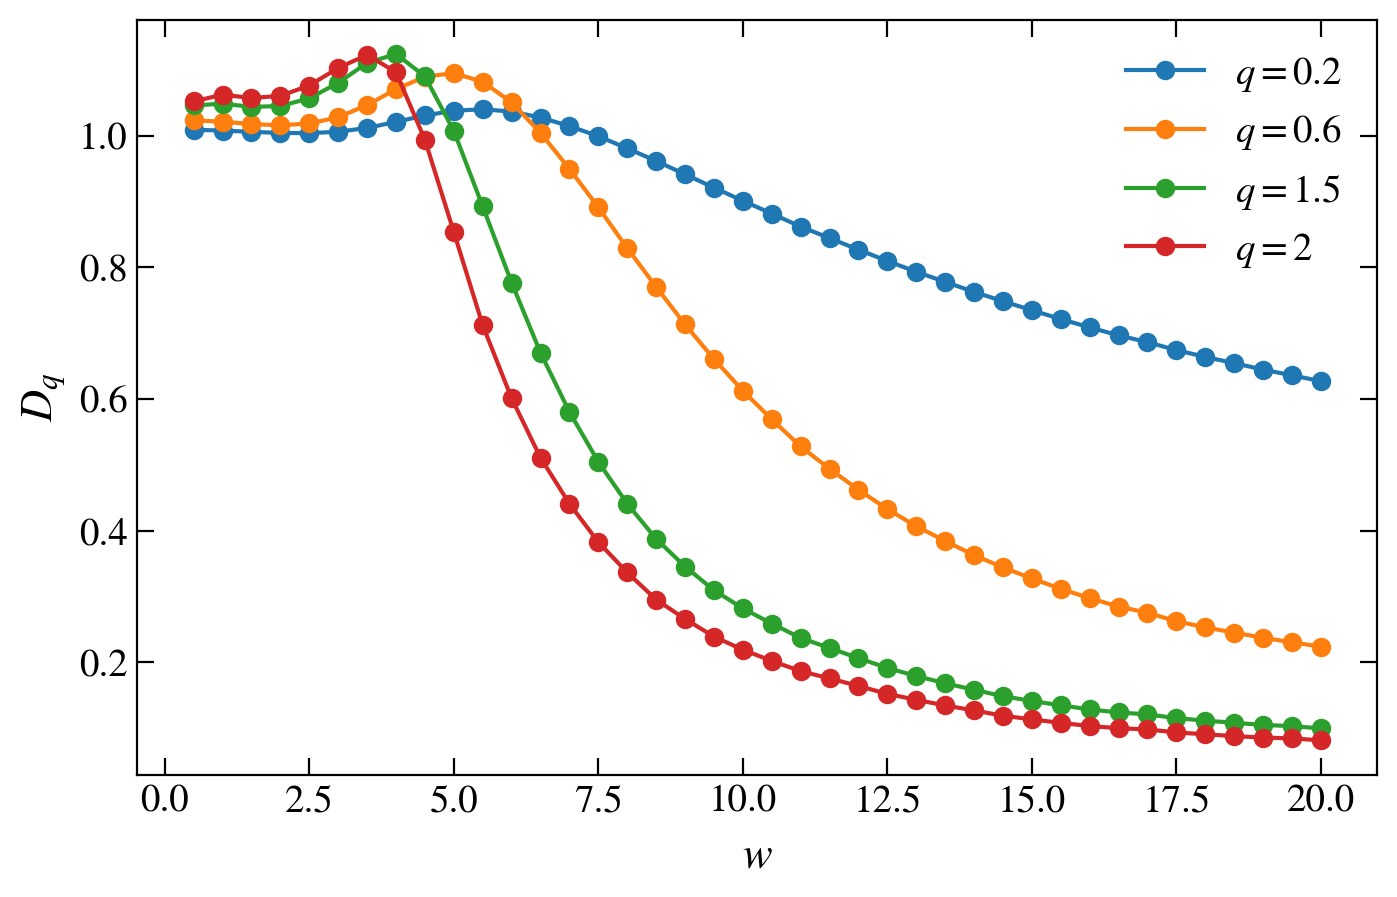

In [56]:

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(8,5), dpi = 200)

L_total=16
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0

qs = np.linspace(0.1, 2.0, 20)
w_vals = np.linspace(0.5, 20.0, 40)
sizes = np.arange(10, 17) - N

w_plot = [2.0, 8.0, 20.0]


q = 1.5
for q in [0.2, 0.6, 1.5, 2.0]:
    q_idx = (np.round(qs, 3)).tolist().index(q)
    Dq = np.zeros((w_vals.size))
    for ii, w in enumerate(w_vals):

        participation = np.zeros((sizes.size))
        for ii_L, L in enumerate(sizes):
            name = base_dir + 'MultiFractality/ParticipationRatio/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
            if exists(name):
                with h5py.File(name, "r") as file:
                    participation[ii_L] = np.array(file.get('500'))[q_idx]
        
        dims = 2**sizes
        Dq_tmp = np.log2(participation[-1] / participation[0]) / np.log2(dims[-1] / dims[0])
        # pars, pconv = fit(exp_fit,
        #                 xdata = sizes[2:],
        #                 ydata = participation[2:])
        # Dq[ii] = pars[0]
        Dq[ii] = -Dq_tmp / (q - 1)

    axis.plot(w_vals, Dq, marker='o', label=r"$q=%g$"%q)


fig_help.set_plot_elements(axis, ylabel=r"$D_q$", xlabel=r"$w$", font_size=14, set_legend=True)#, yscale='log', xscale='log')

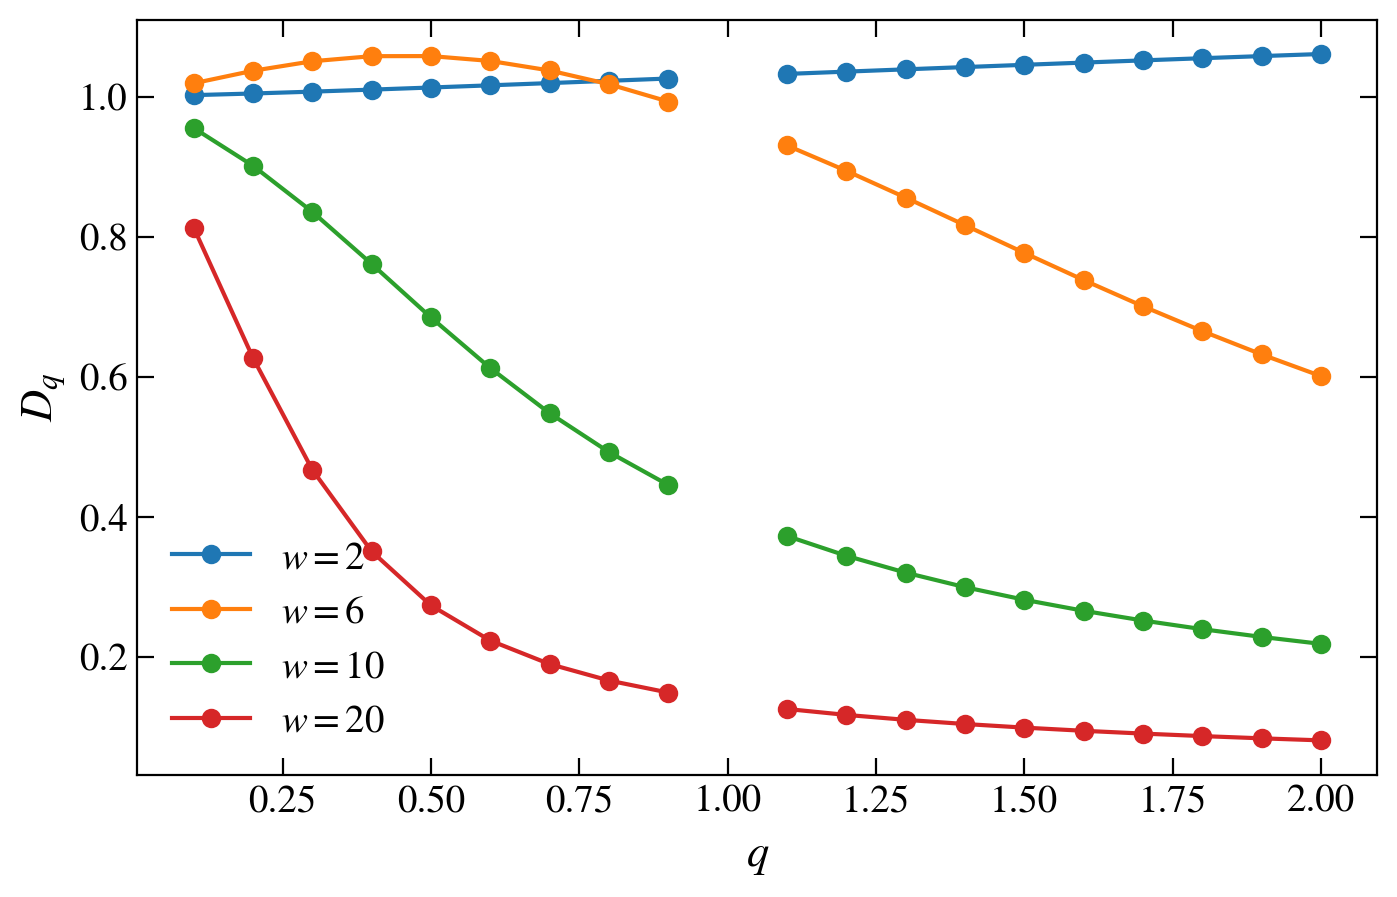

In [66]:

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(8,5), dpi = 200)

L_total=16
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0

qs = np.linspace(0.1, 2.0, 20)
w_vals = [2.0, 6.0, 10.0, 20.0]
sizes = np.arange(10, 17) - N

w_plot = [2.0, 8.0, 20.0]


for ii, w in enumerate(w_vals):

    Dq = np.zeros((qs.size))
    for q_idx, q in enumerate(qs):
        if np.abs(q - 1) > 1e-10:

            participation = np.zeros((sizes.size))
            for ii_L, L in enumerate(sizes):
                name = base_dir + 'MultiFractality/ParticipationRatio/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
                if exists(name):
                    with h5py.File(name, "r") as file:
                        participation[ii_L] = np.array(file.get('500'))[q_idx]
            
            dims = 2**sizes
            Dq_tmp = np.log2(participation[-1] / participation[0]) / np.log2(dims[-1] / dims[0])
            # pars, pconv = fit(exp_fit,
            #                 xdata = sizes[2:],
            #                 ydata = participation[2:])
            # Dq[ii] = pars[0]
            Dq[q_idx] = -Dq_tmp / (q - 1)
        else:
            Dq[q_idx] = np.nan
    axis.plot(qs, Dq, marker='o', label=r"$w=%g$"%w)


fig_help.set_plot_elements(axis, ylabel=r"$D_q$", xlabel=r"$q$", font_size=14, set_legend=True)#, yscale='log', xscale='log')